In [1897]:
import eikon as ek
import numpy as np
import pandas as pd
import json
import datetime as dt
import traceback
import math

# Import Cleaned Data

In [1898]:
price_data = pd.read_csv("price_data_cleaned.csv")

In [1899]:
price_data.describe()

,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,C3 - Close Price,C3 - Accumulated Volume,C4 - Close Price,C4 - Accumulated Volume,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return
count,166554.000000,166554.000000,166554.000000,166554.000000,166554.000000,1.664290e+05,166554.000000,1.665070e+05,162312.000000,1.622760e+05,162312.000000,1.622760e+05,166554.000000,166554.000000,162726.000000,162726.000000
mean,2007.503032,6.555964,15.772128,2.014272,2247.252814,1.925024e+05,2248.873235,1.765483e+05,2290.334560,4.550426e+04,2290.334560,4.550426e+04,0.000187,0.000119,0.000135,0.000135
std,8.644937,3.433873,8.750959,1.399904,10215.661480,3.268517e+06,10218.444864,2.920270e+06,10305.344406,1.103189e+06,10305.344406,1.103189e+06,0.016653,0.015798,0.014556,0.014556
min,1992.000000,1.000000,1.000000,0.000000,-13.100000,0.000000e+00,0.302000,0.000000e+00,0.308000,0.000000e+00,0.308000,0.000000e+00,-0.359333,-0.941776,-0.261407,-0.261407
25%,2000.000000,4.000000,8.000000,1.000000,19.490000,7.530000e+02,19.430000,2.519000e+03,19.800000,9.200000e+02,19.800000,9.200000e+02,-0.006027,-0.005932,-0.005422,-0.005422
50%,2008.000000,7.000000,16.000000,2.000000,111.450000,4.979000e+03,111.700000,1.022200e+04,112.850000,4.084000e+03,112.850000,4.084000e+03,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,10.000000,23.000000,3.000000,502.750000,2.227400e+04,506.875000,3.527050e+04,524.000000,1.610625e+04,524.000000,1.610625e+04,0.006370,0.006090,0.005732,0.005732
max,2021.000000,12.000000,31.000000,6.000000,155880.000000,1.734515e+08,154750.000000,2.790027e+08,154540.000000,1.340868e+08,154540.000000,1.340868e+08,0.479290,0.387716,0.409346,0.409346


# Create Signals & Trading Data Set

In [1900]:
price_data["C1 - C2 Carry"] = price_data["C2 - Close Price"] / price_data["Close Price"] - 1

In [1901]:
price_data["Instrument - Lag"] = price_data.Instrument.shift(1)
price_data["Date - Lag"] = price_data.Date.shift(1)
price_data["C2 - Close Price - Lag"] = price_data["C2 - Close Price"].shift(1)
price_data["Close Price - Lag"] = price_data["Close Price"].shift(1)
price_data["C1 - C2 Carry - Lag"] = price_data["C1 - C2 Carry"].shift(1)

In [1902]:
price_data["Date - Lag"] = price_data[["Instrument - Lag", "Instrument", "Date - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C2 - Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "C2 - Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C1 - C2 Carry - Lag"] = price_data[["Instrument - Lag", "Instrument", "C1 - C2 Carry - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

In [1903]:
trading_data = price_data.copy()

In [1904]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag
0,SB,1992-01-03,1992,1,3,4,8.410,5154.0,8.370,3388.0,...,-0.020955,-0.018757,-0.012972,-0.012972,-0.004756,NaN,NaN,NaN,NaN,NaN
1,SB,1992-01-06,1992,1,6,0,8.500,4996.0,8.440,2751.0,...,0.010702,0.008363,0.003584,0.003584,-0.007059,SB,1992-01-03,8.370,8.410,-0.004756
2,SB,1992-01-07,1992,1,7,1,8.350,4846.0,8.320,4290.0,...,-0.017647,-0.014218,-0.007143,-0.007143,-0.003593,SB,1992-01-06,8.440,8.500,-0.007059
3,SB,1992-01-08,1992,1,8,2,8.430,5456.0,8.460,4665.0,...,0.009581,0.016827,0.014388,0.014388,0.003559,SB,1992-01-07,8.320,8.350,-0.003593
4,SB,1992-01-09,1992,1,9,3,8.450,4213.0,8.440,4566.0,...,0.002372,-0.002364,0.001182,0.001182,-0.001183,SB,1992-01-08,8.460,8.430,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,SI,2021-12-27,2021,12,27,0,22.680,1.0,23.060,108793.0,...,0.000000,0.000000,0.000000,0.000000,0.016755,SI,2021-12-23,22.895,22.835,0.002628
166550,SI,2021-12-28,2021,12,28,1,23.150,211.0,23.015,73451.0,...,0.000000,0.000000,0.000000,0.000000,-0.005832,SI,2021-12-27,23.060,22.680,0.016755
166551,SI,2021-12-29,2021,12,29,2,22.635,172.0,22.825,98976.0,...,0.000000,0.000000,0.000000,0.000000,0.008394,SI,2021-12-28,23.015,23.150,-0.005832
166552,SI,2021-12-30,2021,12,30,3,23.070,344.0,23.100,75359.0,...,0.000000,0.000000,0.000000,0.000000,0.001300,SI,2021-12-29,22.825,22.635,0.008394


In [1905]:
trading_data.Date = pd.to_datetime(trading_data.Date)

Value Baseline

To calculate the value factor we need the average price over the past 5 years. The average excludes the current date to prevent forward-looking bias

In [1906]:
trading_data.sort_values(["Instrument", "Date"], ascending=True, inplace=True)

trading_data["1Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "365d",
    on="Date",
    closed="neither"
)["Close Price"].mean().to_numpy()

trading_data["C2 - 1Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "365d",
    on="Date",
    closed="neither"
)["C2 - Close Price"].mean().to_numpy()

In [1907]:
min_dates = trading_data.groupby("Instrument").agg(
    min_date = ("Date", "min")
).reset_index()

trading_data = trading_data.merge(min_dates, how="left")

trading_data["1Y Average Price"] = trading_data[[
    "1Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 365 else np.nan, axis=1
)
trading_data["C2 - 1Y Average Price"] = trading_data[[
    "C2 - 1Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 365 else np.nan, axis=1
)

We trade on the first available trading day of every month

In [1908]:
trading_data["Daily Adjusted Return"] += 1
trading_data["C2 - Daily Adjusted Return"] += 1
trading_data["C3 - Daily Adjusted Return"] += 1
trading_data["C4 - Daily Adjusted Return"] += 1

In [1909]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag,1Y Average Price,C2 - 1Y Average Price,min_date
0,C,1992-01-03,1992,1,3,4,248.75,23080.0,254.25,5508.0,...,0.993301,0.022111,KW,NaN,NaN,NaN,NaN,NaN,NaN,1992-01-03
1,C,1992-01-06,1992,1,6,0,250.00,20980.0,256.00,4266.0,...,1.005780,0.024000,C,1992-01-03,254.25,248.75,0.022111,NaN,NaN,1992-01-03
2,C,1992-01-07,1992,1,7,1,249.75,11869.0,256.00,4310.0,...,1.001916,0.025025,C,1992-01-06,256.00,250.00,0.024000,NaN,NaN,1992-01-03
3,C,1992-01-08,1992,1,8,2,253.00,18428.0,259.75,4042.0,...,1.009560,0.026680,C,1992-01-07,256.00,249.75,0.025025,NaN,NaN,1992-01-03
4,C,1992-01-09,1992,1,9,3,252.50,20440.0,259.25,6553.0,...,1.001894,0.026733,C,1992-01-08,259.75,253.00,0.026680,NaN,NaN,1992-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,W,2021-12-27,2021,12,27,0,805.75,52917.0,810.00,12813.0,...,0.994419,0.005275,W,2021-12-23,819.00,815.25,0.004600,699.814516,704.992944,1992-01-03
166550,W,2021-12-28,2021,12,28,1,784.00,64228.0,789.50,11353.0,...,0.977237,0.007015,W,2021-12-27,810.00,805.75,0.005275,700.584677,705.778226,1992-01-03
166551,W,2021-12-29,2021,12,29,2,789.25,78959.0,793.00,11679.0,...,1.003510,0.004751,W,2021-12-28,789.50,784.00,0.007015,701.248992,706.460685,1992-01-03
166552,W,2021-12-30,2021,12,30,3,780.50,74145.0,783.50,13878.0,...,0.985692,0.003844,W,2021-12-29,793.00,789.25,0.004751,701.852823,707.088710,1992-01-03


In [1910]:
backtest_data = trading_data.sort_values(
    by="Date",
    ascending=True
).groupby([
    "Instrument", "Year", "Month"
]).agg(
    Day = ("Day", "first"),
    date = ("Date", "first"),
    close_price_lag = ("Close Price - Lag", "first"),
    c2_close_price_lag = ("C2 - Close Price - Lag", "first"),
    c1_c2_carry_signal = ("C1 - C2 Carry - Lag", "first"),
    adj_monthly_return = ("Daily Adjusted Return", "prod"),
    c2_adj_monthly_return = ("C2 - Daily Adjusted Return", "prod"),
    adj_monthly_var = ("Daily Adjusted Return", np.std),
    c2_adj_monthly_var = ("C2 - Daily Adjusted Return", np.std),
    y1_mean_price = ("1Y Average Price", "first"),
    c2_y1_mean_price = ("C2 - 1Y Average Price", "first")
).reset_index()

In [1911]:
backtest_data["momentum_signal"] = (backtest_data.groupby("Instrument").adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").adj_monthly_var.shift(1)

backtest_data["value_signal"] = np.log(backtest_data.groupby("Instrument")["y1_mean_price"].shift(4*12+6) / backtest_data["close_price_lag"])

backtest_data["c2_momentum_signal"] = (backtest_data.groupby("Instrument").c2_adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").c2_adj_monthly_var.shift(1)

backtest_data["c2_value_signal"] = np.log(backtest_data.groupby("Instrument")["c2_y1_mean_price"].shift(4*12+6) / backtest_data["c2_close_price_lag"])

# We only drop NA values for carry & signal now as dropping value would incur a hefty loss in the amount of data
backtest_data.dropna(
    subset=[
        "c1_c2_carry_signal",
        "momentum_signal",
        "c2_momentum_signal"
    ],
    inplace=True
)

In [1912]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011


Basis-Momentum Signal

In [1913]:
backtest_data["c1_c2_basis_momentum_signal"]  = backtest_data.close_price_lag / backtest_data.groupby("Instrument").close_price_lag.shift(12) \
    - backtest_data.c2_close_price_lag / backtest_data.groupby("Instrument").c2_close_price_lag.shift(12)

In [1914]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN,NaN
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN,NaN
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN,NaN
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN,NaN
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226


# Add Risk-Free Rate

In [1915]:
# Read in data
# Retrieved from https://www.multpl.com/1-year-treasury-rate/table/by-month
risk_free_rate = pd.read_csv("us_1yt.csv")
# Transform to a monthly basis
risk_free_rate["risk_free_rate"] = risk_free_rate["risk_free_rate"].apply(lambda x: (1+x)**(1/12) - 1)

In [1916]:
backtest_data = backtest_data.merge(risk_free_rate, how="left")

In [1917]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate
0,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN,NaN,0.003507
1,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN,NaN,0.003779
2,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN,NaN,0.003515
3,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN,NaN,0.003426
4,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN,NaN,0.003410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150


# Build Strategies
For all strategies we assume that 70% of the cash is invested at the risk-free rate while the remaining 30% is used for margin

In [1918]:
# This parameter (ranging from 0-80%) decides how much cash is invested at the risk-free rate
cash_pct = 0.7

## Carry Strategies

In [1919]:
# Rank the carries for each month so we can get the top & bottom percentiles
backtest_data["Carry Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_carry_signal"].rank("average", ascending=True,pct=True )

Positive Carry Test

In [1920]:
positive_carry_test = backtest_data[
    backtest_data["Carry Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1921]:
positive_carry_test["x"] = positive_carry_test["Year"] + (positive_carry_test["Month"] - 1) / 12

In [1922]:
positive_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.970561,0.003507
1,1992.166667,1.008021,0.003779
2,1992.250000,0.977645,0.003515
3,1992.333333,1.007000,0.003426
4,1992.416667,0.994948,0.003410
...,...,...,...
354,2021.583333,1.045636,0.000058
355,2021.666667,0.974312,0.000067
356,2021.750000,1.026724,0.000092
357,2021.833333,1.009064,0.000150


In [1923]:
# Add the risk-free rate and calculate cumulative returns
positive_carry_test["y_tot"] = (2 - positive_carry_test["y"]) + cash_pct * positive_carry_test["rf"]
positive_carry_test["y_cum"] = positive_carry_test["y_tot"].cumprod()

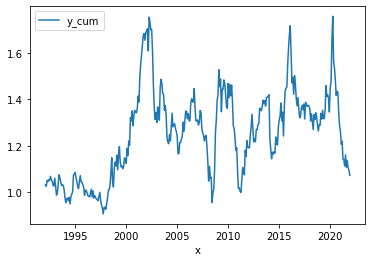

In [1924]:
positive_carry_test.plot.line(x="x", y="y_cum")

In [1925]:
positive_carry_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.000934
std,0.038470
min,0.867066
25%,0.978102
50%,0.998503
75%,1.024761
max,1.146315


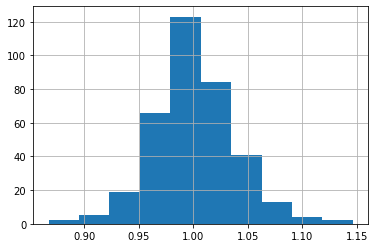

In [1926]:
positive_carry_test["y_tot"].hist()

Negative Carry Test

In [1927]:
negative_carry_test = backtest_data[
    (backtest_data["Carry Rank"] <= 1/3)
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1928]:
negative_carry_test["x"] = negative_carry_test["Year"] + (negative_carry_test["Month"] - 1) / 12

In [1929]:
negative_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.999899,0.003507
1,1992.166667,0.992977,0.003779
2,1992.250000,0.986872,0.003515
3,1992.333333,1.044906,0.003426
4,1992.416667,1.010671,0.003410
...,...,...,...
354,2021.583333,0.980413,0.000058
355,2021.666667,1.041894,0.000067
356,2021.750000,1.005262,0.000092
357,2021.833333,0.955206,0.000150


In [1930]:
# Add the risk-free rate and calculate cumulative returns
negative_carry_test["y_tot"] = negative_carry_test["y"] + cash_pct * negative_carry_test["rf"]
negative_carry_test["y_cum"] = negative_carry_test["y_tot"].cumprod()

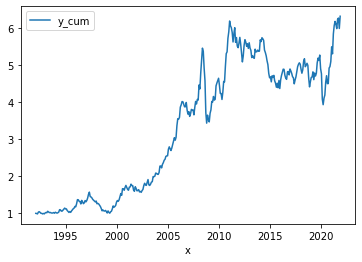

In [1931]:
negative_carry_test.plot.line(x="x", y="y_cum")

In [1932]:
negative_carry_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.005894
std,0.038602
min,0.811096
25%,0.980539
50%,1.002354
75%,1.029387
max,1.120550


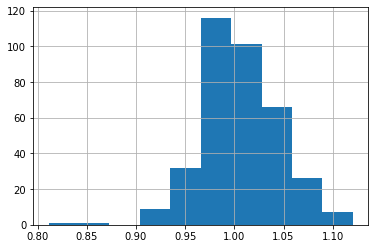

In [1933]:
negative_carry_test["y_tot"].hist()

Combined Carry Test

In [1934]:
# Combine the short & long leg together
combined_carry_test = positive_carry_test[["x", "y_tot", "rf"]].merge(negative_carry_test[["x", "y_tot"]], on="x")

In [1935]:
# We invest 50/50 between the short and long leg
combined_carry_test["y"] = (combined_carry_test["y_tot_x"] + combined_carry_test["y_tot_y"]) / 2

In [1936]:
combined_carry_test[["x", "y"]]

,x,y
0,1992.083333,1.017124
1,1992.166667,0.995123
2,1992.250000,1.007074
3,1992.333333,1.021351
4,1992.416667,1.010248
...,...,...
354,2021.583333,0.967429
355,2021.666667,1.033838
356,2021.750000,0.989334
357,2021.833333,0.973176


In [1937]:
combined_carry_test["y_cum"] = combined_carry_test["y"].cumprod()

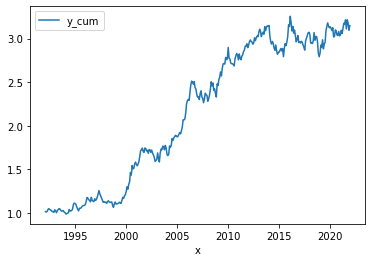

In [1938]:
combined_carry_test.plot.line(x="x", y="y_cum")

In [1939]:
combined_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.003414
std,0.020817
min,0.954016
25%,0.989626
50%,1.002632
75%,1.015160
max,1.078505


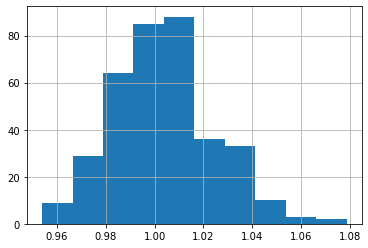

In [1940]:
combined_carry_test["y"].hist()

Equal Weighted Long Commodity Test

In [1941]:
ew_commodity_test = backtest_data.groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1942]:
ew_commodity_test["x"] = ew_commodity_test["Year"] + (ew_commodity_test["Month"] - 1) / 12

In [1943]:
ew_commodity_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.987582,0.003507
1,1992.166667,1.002805,0.003779
2,1992.250000,0.995651,0.003515
3,1992.333333,1.024674,0.003426
4,1992.416667,1.006917,0.003410
...,...,...,...
354,2021.583333,1.005498,0.000058
355,2021.666667,1.007544,0.000067
356,2021.750000,1.011736,0.000092
357,2021.833333,0.993376,0.000150


In [1944]:
ew_commodity_test["y"] = ew_commodity_test["y"] + cash_pct * ew_commodity_test["rf"]
ew_commodity_test["y_cum"] = ew_commodity_test["y"].cumprod()

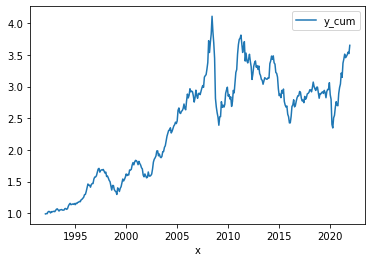

In [1945]:
ew_commodity_test.plot.line(x="x", y="y_cum")

In [1946]:
ew_commodity_test[["y"]].describe()

,y
count,359.000000
mean,1.004114
std,0.031427
min,0.816382
25%,0.984998
50%,1.005579
75%,1.021112
max,1.101357


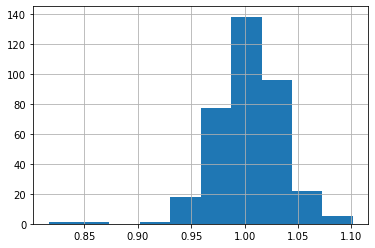

In [1947]:
ew_commodity_test["y"].hist()

## Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [1948]:
backtest_data["c1_c2_momentum_signal"] = (backtest_data["momentum_signal"] + backtest_data["c2_momentum_signal"]) / 2
backtest_data["Momentum Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [1949]:
backtest_data[backtest_data["Momentum Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

89.11968908419607

In [1950]:
backtest_data[backtest_data["Momentum Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

-0.998828980491889

Positive Momentum Test

In [1951]:
positive_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] >= 2/3
].groupby(
    ["Year", "Month"]
).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1952]:
positive_momentum_test["x"] = positive_momentum_test["Year"] + (positive_momentum_test["Month"] - 1) / 12

In [1953]:
positive_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.981155,0.003507
1,1992.166667,1.032154,0.003779
2,1992.250000,1.061608,0.003515
3,1992.333333,1.063997,0.003426
4,1992.416667,1.002342,0.003410
...,...,...,...
354,2021.583333,1.017667,0.000058
355,2021.666667,0.995150,0.000067
356,2021.750000,1.004274,0.000092
357,2021.833333,0.985823,0.000150


In [1954]:
positive_momentum_test["y_tot"] = positive_momentum_test["y"] + cash_pct * positive_momentum_test["rf"]
positive_momentum_test["y_cum"] = positive_momentum_test["y_tot"].cumprod()

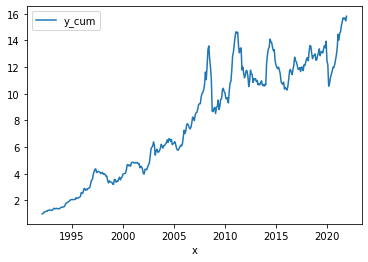

In [1955]:
positive_momentum_test.plot.line(x="x", y="y_cum")

In [1956]:
positive_momentum_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.008574
std,0.041276
min,0.787401
25%,0.987311
50%,1.009451
75%,1.028374
max,1.152269


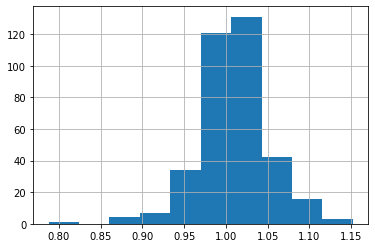

In [1957]:
positive_momentum_test["y_tot"].hist()

Negative Momentum Test

In [1958]:
negative_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1959]:
negative_momentum_test["x"] = negative_momentum_test["Year"] + (negative_momentum_test["Month"] - 1) / 12

In [1960]:
negative_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.986055,0.003507
1,1992.166667,1.002746,0.003779
2,1992.250000,0.982796,0.003515
3,1992.333333,0.997278,0.003426
4,1992.416667,1.043439,0.003410
...,...,...,...
354,2021.583333,1.008900,0.000058
355,2021.666667,0.994908,0.000067
356,2021.750000,1.018235,0.000092
357,2021.833333,0.971956,0.000150


In [1961]:
negative_momentum_test["y_tot"] = (2 - negative_momentum_test["y"]) + cash_pct * negative_momentum_test["rf"]
negative_momentum_test["y_cum"] = (2 - negative_momentum_test["y_tot"]).cumprod()

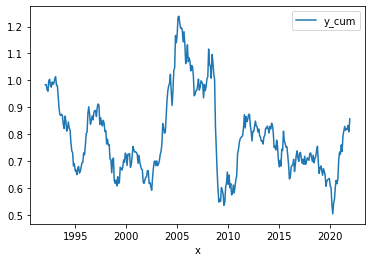

In [1962]:
negative_momentum_test.plot.line(x="x", y="y_cum")

In [1963]:
negative_momentum_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,0.999549
std,0.041974
min,0.874081
25%,0.975171
50%,0.997953
75%,1.024694
max,1.173926


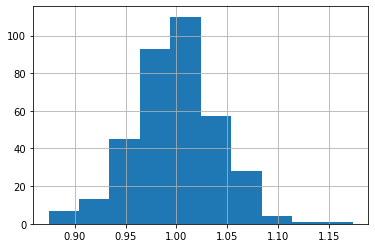

In [1964]:
negative_momentum_test["y_tot"].hist()

Combined Momentum Test

In [1965]:
combined_momentum_test = negative_momentum_test[["x", "y_tot", "rf"]].merge(positive_momentum_test[["x", "y_tot"]], on="x")

In [1966]:
combined_momentum_test["y"] = (combined_momentum_test["y_tot_x"] + combined_momentum_test["y_tot_y"]) / 2

In [1967]:
combined_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.000005
1,1992.166667,1.017349
2,1992.250000,1.041866
3,1992.333333,1.035758
4,1992.416667,0.981839
...,...,...
354,2021.583333,1.004424
355,2021.666667,1.000168
356,2021.750000,0.993083
357,2021.833333,1.007039


In [1968]:
combined_momentum_test["y_cum"] = combined_momentum_test["y"].cumprod()

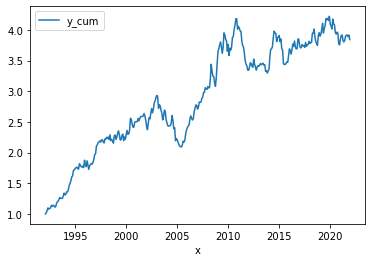

In [1969]:
combined_momentum_test.plot.line(x="x", y="y_cum")

In [1970]:
combined_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.004061
std,0.024765
min,0.912188
25%,0.989591
50%,1.002839
75%,1.018749
max,1.082458


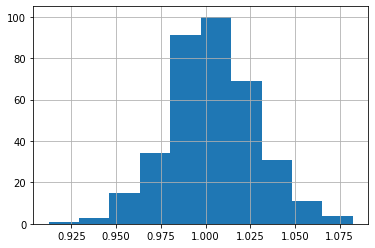

In [1971]:
combined_momentum_test["y"].hist()

## Momentum C2 Contracts
Momentum algorithm using the C2 contracts

Positive Momentum Test

In [1972]:
positive_momentum_c2_test = backtest_data[
    backtest_data["Momentum Rank"] >= 2/3
].groupby(
    ["Year", "Month"]
).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1973]:
positive_momentum_c2_test["x"] = positive_momentum_c2_test["Year"] + (positive_momentum_c2_test["Month"] - 1) / 12

In [1974]:
positive_momentum_c2_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,1.010219,0.003507
1,1992.166667,1.025362,0.003779
2,1992.250000,1.037839,0.003515
3,1992.333333,1.050081,0.003426
4,1992.416667,1.001007,0.003410
...,...,...,...
354,2021.583333,1.013183,0.000058
355,2021.666667,0.993822,0.000067
356,2021.750000,0.998075,0.000092
357,2021.833333,0.983189,0.000150


In [1975]:
positive_momentum_c2_test["y_tot"] = positive_momentum_c2_test["y"] + cash_pct * positive_momentum_c2_test["rf"]
positive_momentum_c2_test["y_cum"] = positive_momentum_c2_test["y_tot"].cumprod()

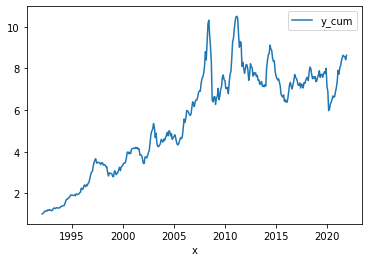

In [1976]:
positive_momentum_c2_test.plot.line(x="x", y="y_cum")

In [1977]:
positive_momentum_c2_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.006826
std,0.039869
min,0.781645
25%,0.985349
50%,1.008709
75%,1.029623
max,1.121219


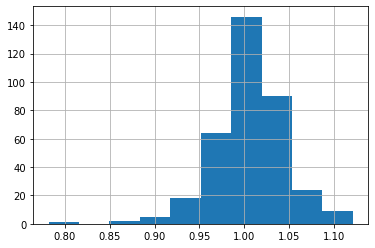

In [1978]:
positive_momentum_c2_test["y_tot"].hist()

Negative Momentum Test

In [1979]:
negative_momentum_c2_test = backtest_data[
    backtest_data["Momentum Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1980]:
negative_momentum_c2_test["x"] = negative_momentum_c2_test["Year"] + (negative_momentum_c2_test["Month"] - 1) / 12

In [1981]:
negative_momentum_c2_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.973414,0.003507
1,1992.166667,0.983976,0.003779
2,1992.250000,0.986067,0.003515
3,1992.333333,1.000212,0.003426
4,1992.416667,1.035952,0.003410
...,...,...,...
354,2021.583333,1.006108,0.000058
355,2021.666667,0.997283,0.000067
356,2021.750000,1.016161,0.000092
357,2021.833333,0.979919,0.000150


In [1982]:
negative_momentum_c2_test["y_tot"] = (2 - negative_momentum_c2_test["y"]) + cash_pct * negative_momentum_c2_test["rf"]
negative_momentum_c2_test["y_cum"] = (2 - negative_momentum_c2_test["y_tot"]).cumprod()

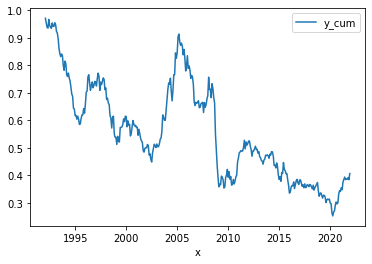

In [1983]:
negative_momentum_c2_test.plot.line(x="x", y="y_cum")

In [1984]:
negative_momentum_c2_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.001679
std,0.040709
min,0.881841
25%,0.976326
50%,1.001922
75%,1.025528
max,1.169819


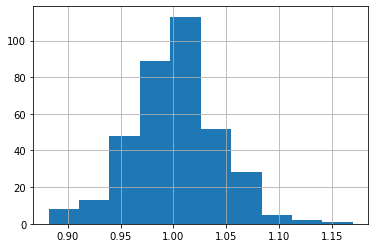

In [1985]:
negative_momentum_c2_test["y_tot"].hist()

Combined Momentum Test

In [1986]:
combined_momentum_c2_test = negative_momentum_c2_test[["x", "y_tot", "rf"]].merge(positive_momentum_c2_test[["x", "y_tot"]], on="x")

In [1987]:
combined_momentum_c2_test["y"] = (combined_momentum_c2_test["y_tot_x"] + combined_momentum_c2_test["y_tot_y"]) / 2

In [1988]:
combined_momentum_c2_test[["x", "y"]]

,x,y
0,1992.083333,1.020857
1,1992.166667,1.023338
2,1992.250000,1.028346
3,1992.333333,1.027333
4,1992.416667,0.984914
...,...,...
354,2021.583333,1.003578
355,2021.666667,0.998316
356,2021.750000,0.991021
357,2021.833333,1.001740


In [1989]:
combined_momentum_c2_test["y_cum"] = combined_momentum_c2_test["y"].cumprod()

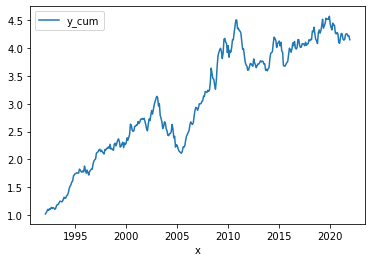

In [1990]:
combined_momentum_c2_test.plot.line(x="x", y="y_cum")

In [1991]:
combined_momentum_c2_test[["y"]].describe()

,y
count,359.000000
mean,1.004253
std,0.023807
min,0.919820
25%,0.990794
50%,1.003104
75%,1.018611
max,1.075448


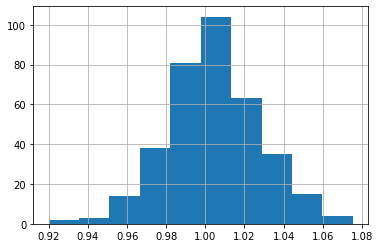

In [1992]:
combined_momentum_c2_test["y"].hist()

## Carry-Momentum V3
Rather than optimizing carry with momentum, we optimize momentum with carry

Negative Momentum-Carry Test

In [1993]:
negative_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] <= 1/3)
].copy()
negative_momentum_carry_v3_test["pick_adj_monthly_return"] = negative_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)

# We calculate this number to see (on average) the % of times that the 1st or 2nd contract
# gets picked by the algorithm
negative_momentum_carry_v3_test["pick_contract"] = negative_momentum_carry_v3_test[[
    "c1_c2_carry_signal"
]].apply(
    lambda x: 0 if x[0] <= 0 else 1,
    axis=1
)

negative_momentum_carry_v3_pick_share = negative_momentum_carry_v3_test.groupby([
    "Year", "Month"
]).agg(
    pick_share = ("pick_contract", lambda x: np.sum(x) / len(x))
).reset_index()

negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [1994]:
negative_momentum_carry_v3_test["x"] = negative_momentum_carry_v3_test["Year"] + (negative_momentum_carry_v3_test["Month"] - 1) / 12

In [1995]:
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
negative_momentum_carry_v3_test.fillna(1, inplace=True)
negative_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [1996]:
negative_momentum_carry_v3_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.973007,0.003507
1,1992.166667,1.001992,0.003779
2,1992.250000,0.982722,0.003515
3,1992.333333,0.996871,0.003426
4,1992.416667,1.031182,0.003410
...,...,...,...
354,2021.583333,1.008222,0.000058
355,2021.666667,0.995705,0.000067
356,2021.750000,1.014796,0.000092
357,2021.833333,0.975646,0.000150


In [1997]:
negative_momentum_carry_v3_test["y_tot"] = (2 - negative_momentum_carry_v3_test["y"]) + cash_pct * negative_momentum_carry_v3_test["rf"]
negative_momentum_carry_v3_test["y_cum"] = negative_momentum_carry_v3_test["y_tot"].cumprod()

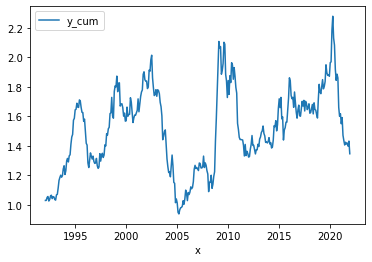

In [1998]:
negative_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [1999]:
negative_momentum_carry_v3_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.001656
std,0.040737
min,0.883060
25%,0.976190
50%,1.002548
75%,1.025182
max,1.170635


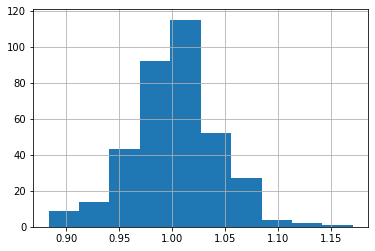

In [2000]:
negative_momentum_carry_v3_test["y_tot"].hist()

Positive Momentum-Carry Test

In [2001]:
positive_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] >= 2/3)
].copy()
positive_momentum_carry_v3_test["pick_adj_monthly_return"] = positive_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)

# We calculate this number to see (on average) the % of times that the 1st or 2nd contract
# gets picked by the algorithm
positive_momentum_carry_v3_test["pick_contract"] = positive_momentum_carry_v3_test[[
    "c1_c2_carry_signal"
]].apply(
    lambda x: 0 if x[0] >= 0 else 1,
    axis=1
)

positive_momentum_carry_v3_pick_share = positive_momentum_carry_v3_test.groupby([
    "Year", "Month"
]).agg(
    pick_share = ("pick_contract", lambda x: np.sum(x) / len(x))
).reset_index()

positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2002]:
positive_momentum_carry_v3_test["x"] = positive_momentum_carry_v3_test["Year"] + (positive_momentum_carry_v3_test["Month"] - 1) / 12

In [2003]:
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
positive_momentum_carry_v3_test.fillna(1, inplace=True)
positive_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [2004]:
positive_momentum_carry_v3_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,1.015966,0.003507
1,1992.166667,1.032154,0.003779
2,1992.250000,1.045401,0.003515
3,1992.333333,1.049480,0.003426
4,1992.416667,1.000193,0.003410
...,...,...,...
354,2021.583333,1.014124,0.000058
355,2021.666667,0.996984,0.000067
356,2021.750000,0.998075,0.000092
357,2021.833333,0.986423,0.000150


In [2005]:
positive_momentum_carry_v3_test["y_tot"] = positive_momentum_carry_v3_test["y"] + cash_pct * positive_momentum_carry_v3_test["rf"]
positive_momentum_carry_v3_test["y_cum"] = positive_momentum_carry_v3_test["y_tot"].cumprod()

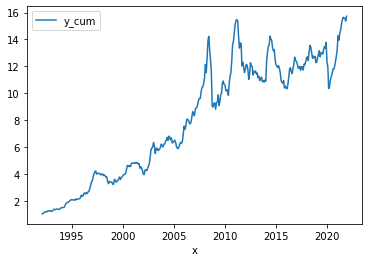

In [2006]:
positive_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [2007]:
positive_momentum_carry_v3_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.008525
std,0.040340
min,0.782980
25%,0.987379
50%,1.009597
75%,1.029325
max,1.134742


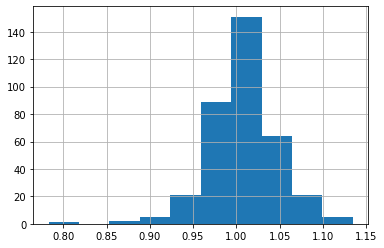

In [2008]:
positive_momentum_carry_v3_test["y_tot"].hist()

Combined Carry Momentum Test

In [2009]:
combined_momentum_carry_test = negative_momentum_carry_v3_test[["x", "y_tot"]].merge(positive_momentum_carry_v3_test[["x", "y_tot"]], on="x", how="outer")

In [2010]:
combined_momentum_carry_test = combined_momentum_carry_test.merge(ew_commodity_test[["x", "rf"]], on="x", how="outer")
combined_momentum_carry_test.fillna(1, inplace=True)
combined_momentum_carry_test.sort_values(by="x", inplace=True)

In [2011]:
combined_momentum_carry_test["y"] = (combined_momentum_carry_test["y_tot_x"] + combined_momentum_carry_test["y_tot_y"]) / 2

In [2012]:
combined_momentum_carry_test[["x", "y"]]

,x,y
0,1992.083333,1.023934
1,1992.166667,1.017726
2,1992.250000,1.033800
3,1992.333333,1.028703
4,1992.416667,0.986893
...,...,...
354,2021.583333,1.002992
355,2021.666667,1.000687
356,2021.750000,0.991703
357,2021.833333,1.005493


In [2013]:
combined_momentum_carry_test["y_cum"] = combined_momentum_carry_test["y"].cumprod()

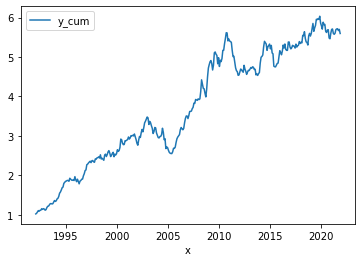

In [2014]:
combined_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2015]:
combined_momentum_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.005090
std,0.023815
min,0.914199
25%,0.990756
50%,1.004610
75%,1.018825
max,1.077589


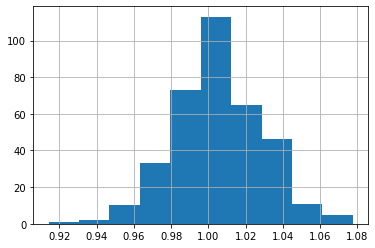

In [2016]:
combined_momentum_carry_test["y"].hist()

## Basis-Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [2017]:
backtest_data_basis_momentum = backtest_data[~pd.isnull(backtest_data.c1_c2_basis_momentum_signal)].copy()

In [2018]:
backtest_data_basis_momentum

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,c1_c2_momentum_signal,Momentum Rank
12,C,1993,2,1,1993-02-01,214.50,222.25,0.036131,0.983683,0.986502,...,240.141434,-1.634837,NaN,-1.320033,NaN,-0.009887,0.002782,0.947368,-1.477435,0.263158
13,C,1993,3,1,1993-03-01,211.00,219.25,0.039100,1.080047,1.069305,...,236.237052,-3.966922,NaN,-4.005884,NaN,-0.003204,0.002734,0.900000,-3.986403,0.200000
14,C,1993,4,1,1993-04-01,230.00,235.50,0.023913,0.993478,0.988323,...,231.908367,11.072632,NaN,6.609377,NaN,-0.003440,0.002661,0.800000,8.841005,1.000000
15,C,1993,5,3,1993-05-03,228.50,232.75,0.018600,0.994679,0.987121,...,230.065476,-0.714555,NaN,-1.227507,NaN,0.005504,0.002758,0.900000,-0.971031,0.500000
16,C,1993,6,1,1993-06-01,224.50,229.50,0.022272,0.992205,0.997821,...,227.715278,-0.551086,NaN,-1.441430,NaN,-0.004193,0.002903,0.850000,-0.996258,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,4.420591,0.740741


In [2019]:
backtest_data_basis_momentum["Basis-Momentum Rank"] = backtest_data_basis_momentum.groupby(["Year", "Month"])["c1_c2_basis_momentum_signal"].rank("average", ascending=True,pct=True)

In [2020]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3].adj_monthly_return.product() - 1

267918.1459640176

In [2021]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] <= 2/3].adj_monthly_return.product() - 1

-0.994664257876897

Positive Momentum Test

In [2022]:
positive_basis_momentum_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2023]:
positive_basis_momentum_test["x"] = positive_basis_momentum_test["Year"] + (positive_basis_momentum_test["Month"] - 1) / 12

In [2024]:
positive_basis_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.028002,0.002782
1,1993.166667,0.999112,0.002734
2,1993.250000,1.045604,0.002661
3,1993.333333,0.941280,0.002758
4,1993.416667,0.987620,0.002903
...,...,...,...
342,2021.583333,1.001686,0.000058
343,2021.666667,1.038310,0.000067
344,2021.750000,1.027688,0.000092
345,2021.833333,0.971770,0.000150


In [2025]:
positive_basis_momentum_test["y_tot"] = positive_basis_momentum_test["y"] + cash_pct * positive_basis_momentum_test["rf"]
positive_basis_momentum_test["y_cum"] = positive_basis_momentum_test["y_tot"].cumprod()

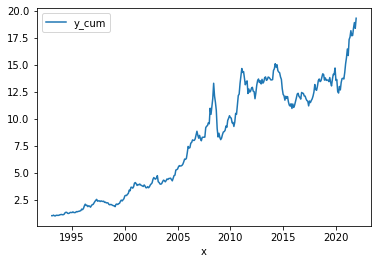

In [2026]:
positive_basis_momentum_test.plot.line(x="x", y="y_cum")

In [2027]:
positive_basis_momentum_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.009371
std,0.040383
min,0.843634
25%,0.983632
50%,1.006602
75%,1.034008
max,1.150452


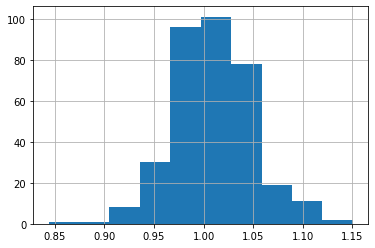

In [2028]:
positive_basis_momentum_test["y_tot"].hist()

Negative Momentum Test

In [2029]:
negative_basis_momentum_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2030]:
negative_basis_momentum_test["x"] = negative_basis_momentum_test["Year"] + (negative_basis_momentum_test["Month"] - 1) / 12

In [2031]:
negative_basis_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.036301,0.002782
1,1993.166667,1.029843,0.002734
2,1993.250000,0.986971,0.002661
3,1993.333333,0.965458,0.002758
4,1993.416667,0.951654,0.002903
...,...,...,...
342,2021.583333,1.026253,0.000058
343,2021.666667,0.988420,0.000067
344,2021.750000,0.982835,0.000092
345,2021.833333,0.993945,0.000150


In [2032]:
negative_basis_momentum_test["y_tot"] = (2 - negative_basis_momentum_test["y"]) + cash_pct * negative_basis_momentum_test["rf"]
negative_basis_momentum_test["y_cum"] = negative_basis_momentum_test["y_tot"].cumprod()

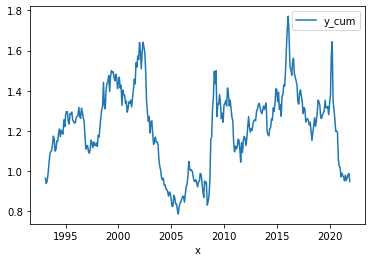

In [2033]:
negative_basis_momentum_test.plot.line(x="x", y="y_cum")

In [2034]:
negative_basis_momentum_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.000669
std,0.040559
min,0.821302
25%,0.977648
50%,0.998960
75%,1.024300
max,1.207202


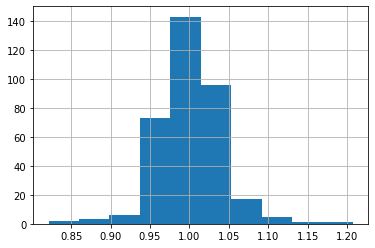

In [2035]:
negative_basis_momentum_test["y_tot"].hist()

Combined Momentum Test

In [2036]:
combined_basis_momentum_test = negative_basis_momentum_test[["x", "y_tot", "rf"]].merge(positive_basis_momentum_test[["x", "y_tot"]], on="x")

In [2037]:
combined_basis_momentum_test["y"] = (combined_basis_momentum_test["y_tot_x"] + combined_basis_momentum_test["y_tot_y"]) / 2

In [2038]:
combined_basis_momentum_test[["x", "y"]]

,x,y
0,1993.083333,0.997798
1,1993.166667,0.986548
2,1993.250000,1.031179
3,1993.333333,0.989841
4,1993.416667,1.020015
...,...,...
342,2021.583333,0.987757
343,2021.666667,1.024992
344,2021.750000,1.022491
345,2021.833333,0.989017


In [2039]:
combined_basis_momentum_test["y_cum"] = combined_basis_momentum_test["y"].cumprod()

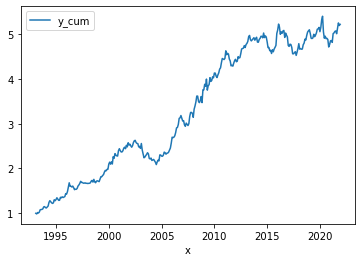

In [2040]:
combined_basis_momentum_test.plot.line(x="x", y="y_cum")

In [2041]:
combined_basis_momentum_test[["y"]].describe()

,y
count,347.000000
mean,1.005020
std,0.022245
min,0.935317
25%,0.990630
50%,1.004125
75%,1.017785
max,1.082676


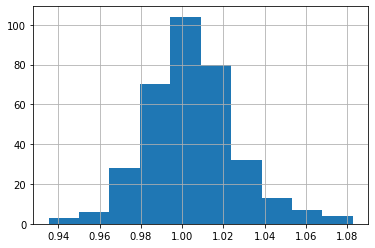

In [2042]:
combined_basis_momentum_test["y"].hist()

## Basis-Momentum C2 Test

Positive Momentum Test

In [2043]:
positive_basis_momentum_c2_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2044]:
positive_basis_momentum_c2_test["x"] = positive_basis_momentum_c2_test["Year"] + (positive_basis_momentum_c2_test["Month"] - 1) / 12

In [2045]:
positive_basis_momentum_c2_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.001797,0.002782
1,1993.166667,1.006584,0.002734
2,1993.250000,1.017144,0.002661
3,1993.333333,0.980060,0.002758
4,1993.416667,0.995609,0.002903
...,...,...,...
342,2021.583333,0.992415,0.000058
343,2021.666667,1.045690,0.000067
344,2021.750000,1.028311,0.000092
345,2021.833333,0.972824,0.000150


In [2046]:
positive_basis_momentum_c2_test["y_tot"] = positive_basis_momentum_c2_test["y"] + cash_pct * positive_basis_momentum_c2_test["rf"]
positive_basis_momentum_c2_test["y_cum"] = positive_basis_momentum_c2_test["y_tot"].cumprod()

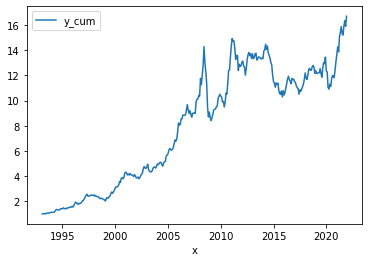

In [2047]:
positive_basis_momentum_c2_test.plot.line(x="x", y="y_cum")

In [2048]:
positive_basis_momentum_c2_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.008878
std,0.038390
min,0.836260
25%,0.984867
50%,1.005811
75%,1.031872
max,1.135756


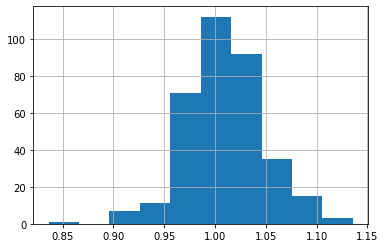

In [2049]:
positive_basis_momentum_c2_test["y_tot"].hist()

Negative Momentum Test

In [2050]:
negative_basis_momentum_c2_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2051]:
negative_basis_momentum_c2_test["x"] = negative_basis_momentum_c2_test["Year"] + (negative_basis_momentum_c2_test["Month"] - 1) / 12

In [2052]:
negative_basis_momentum_c2_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.053448,0.002782
1,1993.166667,1.027921,0.002734
2,1993.250000,0.986599,0.002661
3,1993.333333,0.970043,0.002758
4,1993.416667,0.959916,0.002903
...,...,...,...
342,2021.583333,1.022495,0.000058
343,2021.666667,0.984369,0.000067
344,2021.750000,0.974883,0.000092
345,2021.833333,0.998867,0.000150


In [2053]:
negative_basis_momentum_c2_test["y_tot"] = (2 - negative_basis_momentum_c2_test["y"]) + cash_pct * negative_basis_momentum_c2_test["rf"]
negative_basis_momentum_c2_test["y_cum"] = negative_basis_momentum_c2_test["y_tot"].cumprod()

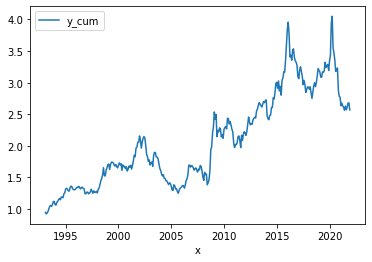

In [2054]:
negative_basis_momentum_c2_test.plot.line(x="x", y="y_cum")

In [2055]:
negative_basis_momentum_c2_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.003462
std,0.038658
min,0.858676
25%,0.979833
50%,1.002174
75%,1.025445
max,1.205752


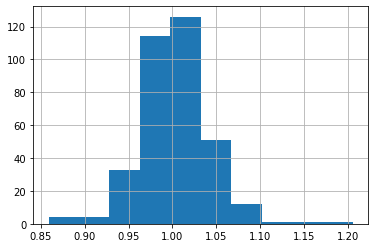

In [2056]:
negative_basis_momentum_c2_test["y_tot"].hist()

Combined Momentum Test

In [2057]:
combined_basis_momentum_c2_test = negative_basis_momentum_c2_test[["x", "y_tot", "rf"]].merge(positive_basis_momentum_c2_test[["x", "y_tot"]], on="x")

In [2058]:
combined_basis_momentum_c2_test["y"] = (combined_basis_momentum_c2_test["y_tot_x"] + combined_basis_momentum_c2_test["y_tot_y"]) / 2

In [2059]:
combined_basis_momentum_c2_test[["x", "y"]]

,x,y
0,1993.083333,0.976122
1,1993.166667,0.991245
2,1993.250000,1.017135
3,1993.333333,1.006939
4,1993.416667,1.019879
...,...,...
342,2021.583333,0.985001
343,2021.666667,1.030707
344,2021.750000,1.026778
345,2021.833333,0.987083


In [2060]:
combined_basis_momentum_c2_test["y_cum"] = combined_basis_momentum_c2_test["y"].cumprod()

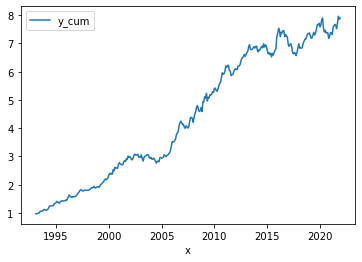

In [2061]:
combined_basis_momentum_c2_test.plot.line(x="x", y="y_cum")

In [2062]:
combined_basis_momentum_c2_test[["y"]].describe()

,y
count,347.000000
mean,1.006170
std,0.020063
min,0.948600
25%,0.992796
50%,1.005913
75%,1.017868
max,1.077041


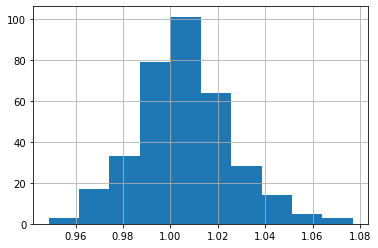

In [2063]:
combined_basis_momentum_c2_test["y"].hist()

## Basis-Momentum-Carry Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [2064]:
backtest_data_basis_momentum = backtest_data[~pd.isnull(backtest_data.c1_c2_basis_momentum_signal)].copy()

In [2065]:
backtest_data_basis_momentum

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,c1_c2_momentum_signal,Momentum Rank
12,C,1993,2,1,1993-02-01,214.50,222.25,0.036131,0.983683,0.986502,...,240.141434,-1.634837,NaN,-1.320033,NaN,-0.009887,0.002782,0.947368,-1.477435,0.263158
13,C,1993,3,1,1993-03-01,211.00,219.25,0.039100,1.080047,1.069305,...,236.237052,-3.966922,NaN,-4.005884,NaN,-0.003204,0.002734,0.900000,-3.986403,0.200000
14,C,1993,4,1,1993-04-01,230.00,235.50,0.023913,0.993478,0.988323,...,231.908367,11.072632,NaN,6.609377,NaN,-0.003440,0.002661,0.800000,8.841005,1.000000
15,C,1993,5,3,1993-05-03,228.50,232.75,0.018600,0.994679,0.987121,...,230.065476,-0.714555,NaN,-1.227507,NaN,0.005504,0.002758,0.900000,-0.971031,0.500000
16,C,1993,6,1,1993-06-01,224.50,229.50,0.022272,0.992205,0.997821,...,227.715278,-0.551086,NaN,-1.441430,NaN,-0.004193,0.002903,0.850000,-0.996258,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,4.420591,0.740741


In [2066]:
backtest_data_basis_momentum["Basis-Momentum Rank"] = backtest_data_basis_momentum.groupby(["Year", "Month"])["c1_c2_basis_momentum_signal"].rank("average", ascending=True,pct=True)

In [2067]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3].adj_monthly_return.product() - 1

267918.1459640176

In [2068]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] <= 2/3].adj_monthly_return.product() - 1

-0.994664257876897

Positive Momentum Test

In [2069]:
positive_basis_momentum_carry_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].copy()
positive_basis_momentum_carry_test["pick_adj_monthly_return"] = positive_basis_momentum_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)

# We calculate this number to see (on average) the % of times that the 1st or 2nd contract
# gets picked by the algorithm
positive_basis_momentum_carry_test["pick_contract"] = positive_basis_momentum_carry_test[[
    "c1_c2_carry_signal"
]].apply(
    lambda x: 0 if x[0] >= 0 else 1,
    axis=1
)

positive_basis_momentum_carry_pick_share = positive_basis_momentum_carry_test.groupby([
    "Year", "Month"
]).agg(
    pick_share = ("pick_contract", lambda x: np.sum(x) / len(x))
).reset_index()

positive_basis_momentum_carry_test = positive_basis_momentum_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2070]:
positive_basis_momentum_carry_test["x"] = positive_basis_momentum_carry_test["Year"] + (positive_basis_momentum_carry_test["Month"] - 1) / 12

In [2071]:
positive_basis_momentum_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.011024,0.002782
1,1993.166667,1.005288,0.002734
2,1993.250000,1.034902,0.002661
3,1993.333333,0.980971,0.002758
4,1993.416667,0.997139,0.002903
...,...,...,...
342,2021.583333,0.991638,0.000058
343,2021.666667,1.042367,0.000067
344,2021.750000,1.026057,0.000092
345,2021.833333,0.975745,0.000150


In [2072]:
positive_basis_momentum_carry_test["y_tot"] = positive_basis_momentum_carry_test["y"] + cash_pct * positive_basis_momentum_carry_test["rf"]
positive_basis_momentum_carry_test["y_cum"] = positive_basis_momentum_carry_test["y_tot"].cumprod()

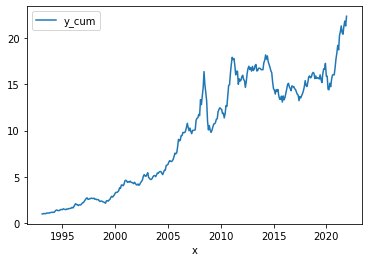

In [2073]:
positive_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2074]:
positive_basis_momentum_carry_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.009738
std,0.038836
min,0.836206
25%,0.984455
50%,1.007048
75%,1.033997
max,1.148019


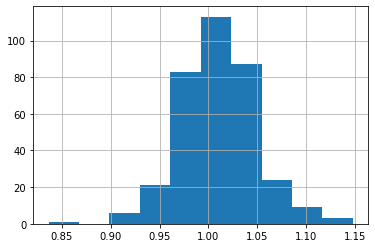

In [2075]:
positive_basis_momentum_carry_test["y_tot"].hist()

Negative Momentum Test

In [2076]:
negative_basis_momentum_carry_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].copy()
negative_basis_momentum_carry_test["pick_adj_monthly_return"] = negative_basis_momentum_carry_test[[
    "adj_monthly_return",
   "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)

# We calculate this number to see (on average) the % of times that the 1st or 2nd contract
# gets picked by the algorithm
negative_basis_momentum_carry_test["pick_contract"] = negative_basis_momentum_carry_test[[
    "c1_c2_carry_signal"
]].apply(
    lambda x: 0 if x[0] <= 0 else 1,
    axis=1
)

negative_basis_momentum_carry_pick_share = negative_basis_momentum_carry_test.groupby([
    "Year", "Month"
]).agg(
    pick_share = ("pick_contract", lambda x: np.sum(x) / len(x))
).reset_index()

negative_basis_momentum_carry_test = negative_basis_momentum_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2077]:
negative_basis_momentum_carry_test["x"] = negative_basis_momentum_carry_test["Year"] + (negative_basis_momentum_carry_test["Month"] - 1) / 12

In [2078]:
negative_basis_momentum_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.031277,0.002782
1,1993.166667,1.027638,0.002734
2,1993.250000,0.986280,0.002661
3,1993.333333,0.969054,0.002758
4,1993.416667,0.952148,0.002903
...,...,...,...
342,2021.583333,1.023969,0.000058
343,2021.666667,0.984118,0.000067
344,2021.750000,0.978441,0.000092
345,2021.833333,0.996796,0.000150


In [2079]:
negative_basis_momentum_carry_test["y_tot"] = (2 - negative_basis_momentum_carry_test["y"]) + cash_pct * negative_basis_momentum_carry_test["rf"]
negative_basis_momentum_carry_test["y_cum"] = negative_basis_momentum_carry_test["y_tot"].cumprod()

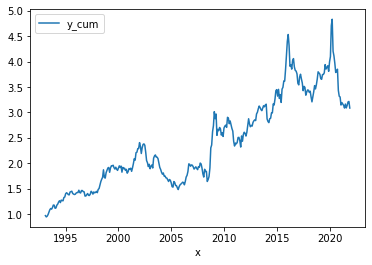

In [2080]:
negative_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2081]:
negative_basis_momentum_carry_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.003989
std,0.038598
min,0.858676
25%,0.980287
50%,1.003748
75%,1.025456
max,1.206567


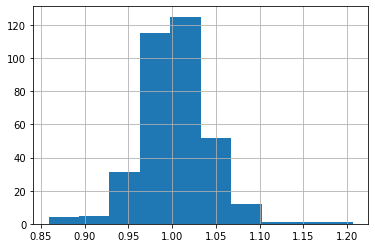

In [2082]:
negative_basis_momentum_carry_test["y_tot"].hist()

Combined Momentum Test

In [2083]:
combined_basis_momentum_carry_test = negative_basis_momentum_carry_test[["x", "y_tot", "rf"]].merge(positive_basis_momentum_carry_test[["x", "y_tot"]], on="x")

In [2084]:
combined_basis_momentum_carry_test["y"] = (combined_basis_momentum_carry_test["y_tot_x"] + combined_basis_momentum_carry_test["y_tot_y"]) / 2

In [2085]:
combined_basis_momentum_carry_test[["x", "y"]]

C:\Users\yvesd\Anaconda3\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,x,y
0,1993.083333,0.991821
1,1993.166667,0.990739
2,1993.250000,1.026173
3,1993.333333,1.007889
4,1993.416667,1.024527
...,...,...
342,2021.583333,0.983875
343,2021.666667,1.029171
344,2021.750000,1.023872
345,2021.833333,0.989580


In [2086]:
combined_basis_momentum_carry_test["y_cum"] = combined_basis_momentum_carry_test["y"].cumprod()

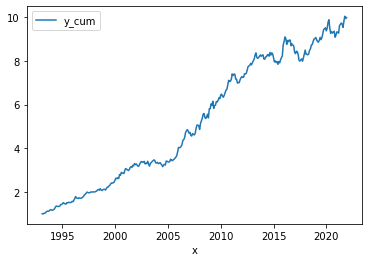

In [2087]:
combined_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [2088]:
combined_basis_momentum_carry_test[["y"]].describe()

,y
count,347.000000
mean,1.006864
std,0.020490
min,0.945957
25%,0.992736
50%,1.006212
75%,1.019135
max,1.077995


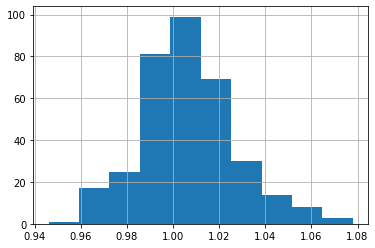

In [2089]:
combined_basis_momentum_carry_test["y"].hist()

## Value Test

Rank the value for each month so we can get the top & bottom percentiles

In [2090]:
backtest_data_value = backtest_data[~pd.isnull(backtest_data.value_signal)].copy()

In [2091]:
backtest_data_value

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,c1_c2_momentum_signal,Momentum Rank
65,C,1997,7,1,1997-07-01,248.50,238.00,-0.042254,0.997047,1.063998,...,295.040675,-7.035649,-0.043005,-6.689042,0.022085,-0.115842,0.004503,0.166667,-6.862345,0.277778
66,C,1997,8,1,1997-08-01,265.00,267.00,0.007547,1.001887,1.006554,...,283.998016,-0.115449,-0.121166,3.624374,-0.106021,-0.084729,0.004519,0.684211,1.754463,0.578947
67,C,1997,9,2,1997-09-02,265.50,268.75,0.012241,0.995707,1.006667,...,278.003968,0.084522,-0.140012,0.304606,-0.128946,-0.065617,0.004488,0.736842,0.194564,0.473684
68,C,1997,10,1,1997-10-01,257.50,266.50,0.034951,1.086408,1.085366,...,273.485119,-0.234639,-0.128345,0.574452,-0.139032,-0.008202,0.004440,0.900000,0.169907,0.600000
69,C,1997,11,3,1997-11-03,279.75,289.25,0.033959,0.969616,0.970614,...,273.650794,5.247790,-0.219570,5.431540,-0.228927,-0.008770,0.004440,0.900000,5.339665,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,4.420591,0.740741


In [2092]:
backtest_data_value["c1_c2_value_signal"] = (backtest_data_value["value_signal"] + backtest_data_value["c2_value_signal"]) / 2
backtest_data_value["Value Rank"] = backtest_data_value.groupby(["Year", "Month"])["c1_c2_value_signal"].rank("average", ascending=True,pct=True)

In [2093]:
backtest_data_value[backtest_data_value["Value Rank"] >= 2/3].adj_monthly_return.product() - 1

834.1664201782403

In [2094]:
backtest_data_value[backtest_data_value["Value Rank"] <= 1/3].adj_monthly_return.product() - 1

-0.8573351429105511

Positive Value Test

In [2095]:
positive_value_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2096]:
positive_value_test["x"] = positive_value_test["Year"] + (positive_value_test["Month"] - 1) / 12

In [2097]:
positive_value_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,1.053600,0.004503
1,1997.583333,0.966751,0.004519
2,1997.666667,1.027404,0.004488
3,1997.750000,0.972897,0.004440
4,1997.833333,0.959697,0.004440
...,...,...,...
289,2021.583333,1.040431,0.000058
290,2021.666667,0.984052,0.000067
291,2021.750000,0.996471,0.000092
292,2021.833333,0.982720,0.000150


In [2098]:
positive_value_test["y_tot"] = positive_value_test["y"] + cash_pct * positive_value_test["rf"]
positive_value_test["y_cum"] = positive_value_test["y_tot"].cumprod()

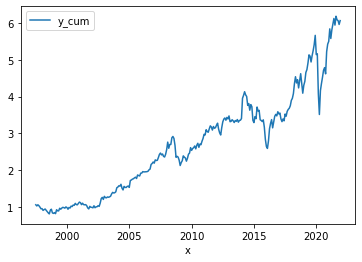

In [2099]:
positive_value_test.plot.line(x="x", y="y_cum")

In [2100]:
positive_value_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,1.007159
std,0.044918
min,0.789539
25%,0.982841
50%,1.009383
75%,1.032815
max,1.184924


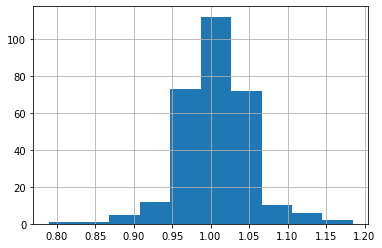

In [2101]:
positive_value_test["y_tot"].hist()

Negative Value Test

In [2102]:
negative_value_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2103]:
negative_value_test["x"] = negative_value_test["Year"] + (negative_value_test["Month"] - 1) / 12

In [2104]:
negative_value_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,0.994577,0.004503
1,1997.583333,0.990811,0.004519
2,1997.666667,0.968856,0.004488
3,1997.750000,0.991536,0.004440
4,1997.833333,0.990388,0.004440
...,...,...,...
289,2021.583333,1.001915,0.000058
290,2021.666667,1.011672,0.000067
291,2021.750000,1.009841,0.000092
292,2021.833333,0.979838,0.000150


In [2105]:
negative_value_test["y_tot"] = (2 - negative_value_test["y"]) + cash_pct * negative_value_test["rf"]
negative_value_test["y_cum"] = negative_value_test["y_tot"].cumprod()

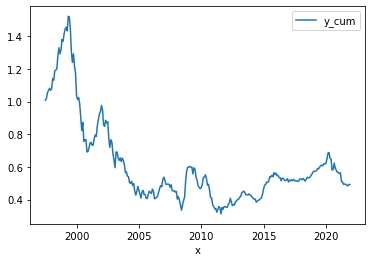

In [2106]:
negative_value_test.plot.line(x="x", y="y_cum")

In [2107]:
negative_value_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,0.998681
std,0.046982
min,0.866185
25%,0.976094
50%,1.001713
75%,1.021486
max,1.238450


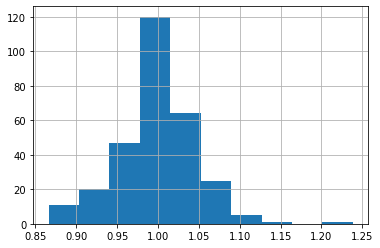

In [2108]:
negative_value_test["y_tot"].hist()

Combined Value Test

In [2109]:
combined_value_test = negative_value_test[["x", "y_tot", "rf"]].merge(positive_value_test[["x", "y_tot"]], on="x")

In [2110]:
combined_value_test["y"] = (combined_value_test["y_tot_x"] + combined_value_test["y_tot_y"]) / 2

In [2111]:
combined_value_test[["x", "y"]]

,x,y
0,1997.500000,1.032664
1,1997.583333,0.991133
2,1997.666667,1.032416
3,1997.750000,0.993789
4,1997.833333,0.987763
...,...,...
289,2021.583333,1.019299
290,2021.666667,0.986237
291,2021.750000,0.993379
292,2021.833333,1.001546


In [2112]:
combined_value_test["y_cum"] = combined_value_test["y"].cumprod()

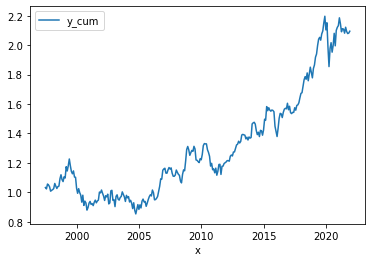

In [2113]:
combined_value_test.plot.line(x="x", y="y_cum")

In [2114]:
combined_value_test[["y"]].describe()

,y
count,294.000000
mean,1.002920
std,0.028365
min,0.923297
25%,0.983955
50%,1.003905
75%,1.021567
max,1.088237


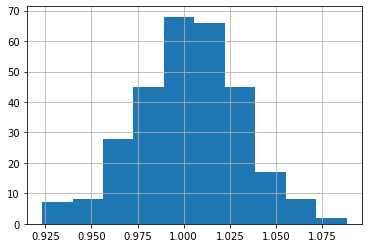

In [2115]:
combined_value_test["y"].hist()

## Value - C2

Positive Value Test

In [2116]:
positive_value_c2_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2117]:
positive_value_c2_test["x"] = positive_value_c2_test["Year"] + (positive_value_c2_test["Month"] - 1) / 12

In [2118]:
positive_value_c2_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,1.055509,0.004503
1,1997.583333,0.966722,0.004519
2,1997.666667,1.021117,0.004488
3,1997.750000,0.978690,0.004440
4,1997.833333,0.964881,0.004440
...,...,...,...
289,2021.583333,1.038609,0.000058
290,2021.666667,0.984518,0.000067
291,2021.750000,0.995753,0.000092
292,2021.833333,0.987628,0.000150


In [2119]:
positive_value_c2_test["y_tot"] = positive_value_c2_test["y"] + cash_pct * positive_value_c2_test["rf"]
positive_value_c2_test["y_cum"] = positive_value_c2_test["y_tot"].cumprod()

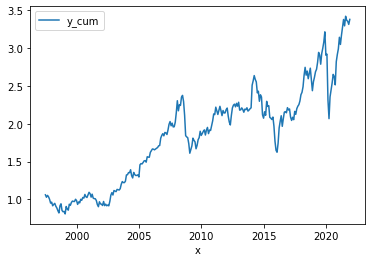

In [2120]:
positive_value_c2_test.plot.line(x="x", y="y_cum")

In [2121]:
positive_value_c2_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,1.005056
std,0.042425
min,0.792181
25%,0.981762
50%,1.005876
75%,1.031243
max,1.139473


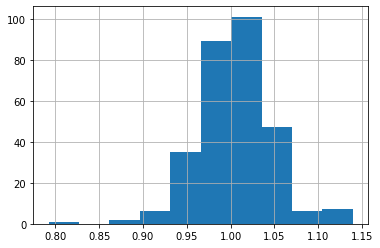

In [2122]:
positive_value_c2_test["y_tot"].hist()

Negative Value Test

In [2123]:
negative_value_c2_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2124]:
negative_value_c2_test["x"] = negative_value_c2_test["Year"] + (negative_value_c2_test["Month"] - 1) / 12

In [2125]:
negative_value_c2_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,0.974312,0.004503
1,1997.583333,1.012975,0.004519
2,1997.666667,0.976343,0.004488
3,1997.750000,0.990330,0.004440
4,1997.833333,0.994717,0.004440
...,...,...,...
289,2021.583333,1.000620,0.000058
290,2021.666667,1.013618,0.000067
291,2021.750000,1.009696,0.000092
292,2021.833333,0.983198,0.000150


In [2126]:
negative_value_c2_test["y_tot"] = (2 - negative_value_c2_test["y"]) + cash_pct * negative_value_c2_test["rf"]
negative_value_c2_test["y_cum"] = negative_value_c2_test["y_tot"].cumprod()

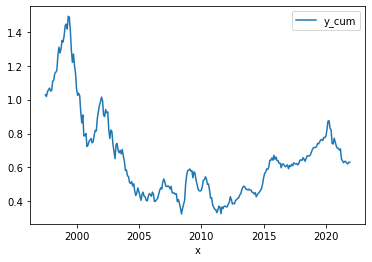

In [2127]:
negative_value_c2_test.plot.line(x="x", y="y_cum")

In [2128]:
negative_value_c2_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,0.999479
std,0.045953
min,0.863586
25%,0.978195
50%,1.002563
75%,1.025699
max,1.239742


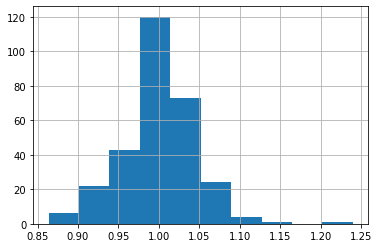

In [2129]:
negative_value_c2_test["y_tot"].hist()

Combined Value Test

In [2130]:
combined_value_c2_test = negative_value_c2_test[["x", "y_tot", "rf"]].merge(positive_value_c2_test[["x", "y_tot"]], on="x")

In [2131]:
combined_value_c2_test["y"] = (combined_value_c2_test["y_tot_x"] + combined_value_c2_test["y_tot_y"]) / 2

In [2132]:
combined_value_c2_test[["x", "y"]]

,x,y
0,1997.500000,1.043751
1,1997.583333,0.980037
2,1997.666667,1.025528
3,1997.750000,0.997288
4,1997.833333,0.988190
...,...,...
289,2021.583333,1.019035
290,2021.666667,0.985497
291,2021.750000,0.993093
292,2021.833333,1.002320


In [2133]:
combined_value_c2_test["y_cum"] = combined_value_c2_test["y"].cumprod()

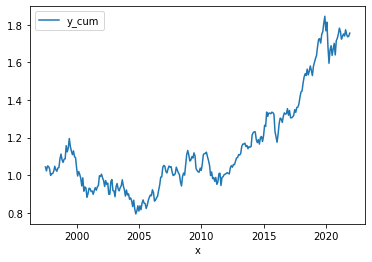

In [2134]:
combined_value_c2_test.plot.line(x="x", y="y_cum")

In [2135]:
combined_value_c2_test[["y"]].describe()

,y
count,294.000000
mean,1.002268
std,0.026483
min,0.927446
25%,0.984642
50%,1.003287
75%,1.019316
max,1.074949


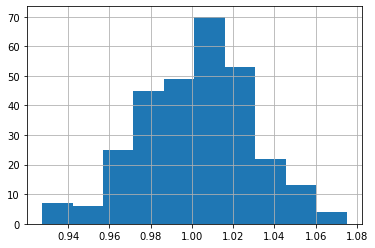

In [2136]:
combined_value_c2_test["y"].hist()

## Value-Carry

Rank the value for each month so we can get the top & bottom percentiles

In [2137]:
backtest_data_value = backtest_data[~pd.isnull(backtest_data.value_signal)].copy()

In [2138]:
backtest_data_value

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,c1_c2_momentum_signal,Momentum Rank
65,C,1997,7,1,1997-07-01,248.50,238.00,-0.042254,0.997047,1.063998,...,295.040675,-7.035649,-0.043005,-6.689042,0.022085,-0.115842,0.004503,0.166667,-6.862345,0.277778
66,C,1997,8,1,1997-08-01,265.00,267.00,0.007547,1.001887,1.006554,...,283.998016,-0.115449,-0.121166,3.624374,-0.106021,-0.084729,0.004519,0.684211,1.754463,0.578947
67,C,1997,9,2,1997-09-02,265.50,268.75,0.012241,0.995707,1.006667,...,278.003968,0.084522,-0.140012,0.304606,-0.128946,-0.065617,0.004488,0.736842,0.194564,0.473684
68,C,1997,10,1,1997-10-01,257.50,266.50,0.034951,1.086408,1.085366,...,273.485119,-0.234639,-0.128345,0.574452,-0.139032,-0.008202,0.004440,0.900000,0.169907,0.600000
69,C,1997,11,3,1997-11-03,279.75,289.25,0.033959,0.969616,0.970614,...,273.650794,5.247790,-0.219570,5.431540,-0.228927,-0.008770,0.004440,0.900000,5.339665,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,4.420591,0.740741


In [2139]:
backtest_data_value["c1_c2_value_signal"] = (backtest_data_value["value_signal"] + backtest_data_value["c2_value_signal"]) / 2
backtest_data_value["Value Rank"] = backtest_data_value.groupby(["Year", "Month"])["c1_c2_value_signal"].rank("average", ascending=True,pct=True)

In [2140]:
backtest_data_value[backtest_data_value["Value Rank"] >= 2/3].adj_monthly_return.product() - 1

834.1664201782403

In [2141]:
backtest_data_value[backtest_data_value["Value Rank"] <= 1/3].adj_monthly_return.product() - 1

-0.8573351429105511

Positive Value Test

In [2142]:
positive_value_carry_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].copy()
positive_value_carry_test["pick_adj_monthly_return"] = positive_value_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)

# We calculate this number to see (on average) the % of times that the 1st or 2nd contract
# gets picked by the algorithm
positive_value_carry_test["pick_contract"] = positive_value_carry_test[[
    "c1_c2_carry_signal"
]].apply(
    lambda x: 0 if x[0] >= 0 else 1,
    axis=1
)

positive_value_carry_pick_share = positive_value_carry_test.groupby([
    "Year", "Month"
]).agg(
    pick_share = ("pick_contract", lambda x: np.sum(x) / len(x))
).reset_index()

positive_value_carry_test = positive_value_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2143]:
positive_value_carry_test["x"] = positive_value_carry_test["Year"] + (positive_value_carry_test["Month"] - 1) / 12

In [2144]:
positive_value_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,1.053600,0.004503
1,1997.583333,0.967950,0.004519
2,1997.666667,1.027404,0.004488
3,1997.750000,0.978417,0.004440
4,1997.833333,0.961172,0.004440
...,...,...,...
289,2021.583333,1.038966,0.000058
290,2021.666667,0.986451,0.000067
291,2021.750000,0.998585,0.000092
292,2021.833333,0.985207,0.000150


In [2145]:
positive_value_carry_test["y_tot"] = positive_value_carry_test["y"] + cash_pct * positive_value_carry_test["rf"]
positive_value_carry_test["y_cum"] = positive_value_carry_test["y_tot"].cumprod()

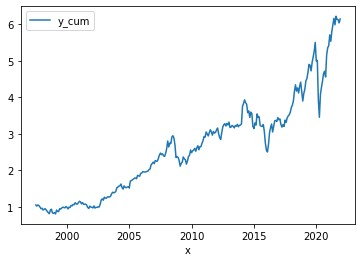

In [2146]:
positive_value_carry_test.plot.line(x="x", y="y_cum")

In [2147]:
positive_value_carry_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,1.007180
std,0.044418
min,0.786574
25%,0.981912
50%,1.009184
75%,1.033115
max,1.180489


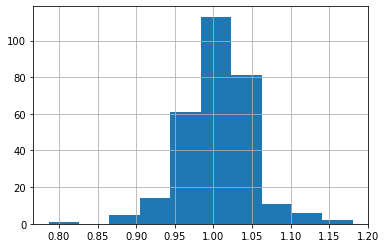

In [2148]:
positive_value_carry_test["y_tot"].hist()

Negative Value Test

In [2149]:
negative_value_carry_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].copy()
negative_value_carry_test["pick_adj_monthly_return"] = negative_value_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)

# We calculate this number to see (on average) the % of times that the 1st or 2nd contract
# gets picked by the algorithm
negative_value_carry_test["pick_contract"] = negative_value_carry_test[[
    "c1_c2_carry_signal"
]].apply(
    lambda x: 0 if x[0] <= 0 else 1,
    axis=1
)

negative_value_carry_pick_share = negative_value_carry_test.groupby([
    "Year", "Month"
]).agg(
    pick_share = ("pick_contract", lambda x: np.sum(x) / len(x))
).reset_index()

negative_value_carry_test = negative_value_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [2150]:
negative_value_carry_test["x"] = negative_value_carry_test["Year"] + (negative_value_carry_test["Month"] - 1) / 12

In [2151]:
negative_value_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,0.991423,0.004503
1,1997.583333,0.980594,0.004519
2,1997.666667,0.971705,0.004488
3,1997.750000,0.993540,0.004440
4,1997.833333,0.991145,0.004440
...,...,...,...
289,2021.583333,1.003085,0.000058
290,2021.666667,1.012708,0.000067
291,2021.750000,1.010720,0.000092
292,2021.833333,0.979394,0.000150


In [2152]:
negative_value_carry_test["y_tot"] = (2 - negative_value_carry_test["y"]) + cash_pct * negative_value_carry_test["rf"]
negative_value_carry_test["y_cum"] = (2 - negative_value_carry_test["y_tot"]).cumprod()

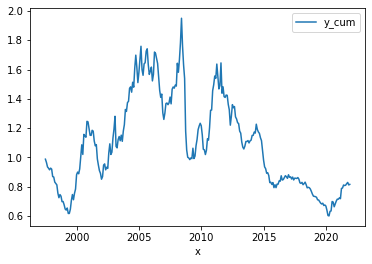

In [2153]:
negative_value_carry_test.plot.line(x="x", y="y_cum")

In [2154]:
negative_value_carry_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,0.999587
std,0.046804
min,0.865976
25%,0.975907
50%,1.002947
75%,1.024320
max,1.233605


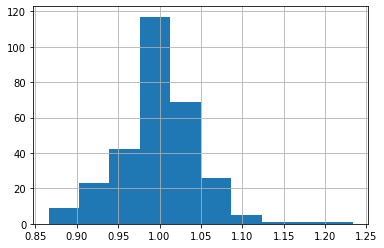

In [2155]:
negative_value_carry_test["y_tot"].hist()

Combined Value Test

In [2156]:
combined_value_carry_test = negative_value_carry_test[["x", "y_tot", "rf"]].merge(positive_value_carry_test[["x", "y_tot"]], on="x")

In [2157]:
combined_value_carry_test["y"] = (combined_value_carry_test["y_tot_x"] + combined_value_carry_test["y_tot_y"]) / 2

In [2158]:
combined_value_carry_test[["x", "y"]]

,x,y
0,1997.500000,1.034241
1,1997.583333,0.996841
2,1997.666667,1.030991
3,1997.750000,0.995546
4,1997.833333,0.988121
...,...,...
289,2021.583333,1.017981
290,2021.666667,0.986918
291,2021.750000,0.993997
292,2021.833333,1.003011


In [2159]:
combined_value_carry_test["y_cum"] = combined_value_carry_test["y"].cumprod()

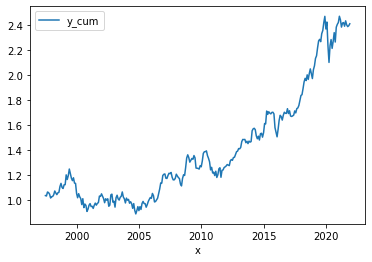

In [2160]:
combined_value_carry_test.plot.line(x="x", y="y_cum")

In [2161]:
combined_value_carry_test[["y"]].describe()

,y
count,294.000000
mean,1.003383
std,0.027699
min,0.921360
25%,0.985185
50%,1.004159
75%,1.021163
max,1.086001


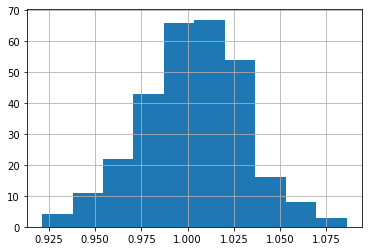

In [2162]:
combined_value_carry_test["y"].hist()

# Output Plots

combined_carry_test.to_csv("combined_carry_test.csv", index=False)
ew_commodity_test.to_csv("ew_test.csv", index=False)
combined_momentum_test.to_csv("combined_momentum_test.csv", index=False)
combined_momentum_carry_test.to_csv("combined_carry_momentum_v3_test.csv", index=False)
combined_basis_momentum_test.to_csv("combined_basis_momentum_test.csv", index=False)
combined_basis_momentum_carry_test.to_csv("combined_basis_momentum_carry_test.csv", index=False)
combined_value_test.to_csv("combined_value_test.csv", index=False)
combined_value_carry_test.to_csv("combined_value_carry_test.csv", index=False)

In [2163]:
import matplotlib.pyplot as plt
import numpy as np

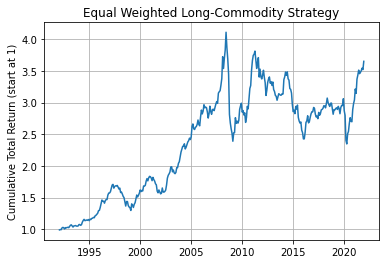

In [2164]:
fig, ax = plt.subplots()
ax.plot(ew_commodity_test["x"], ew_commodity_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Equal Weighted Long-Commodity Strategy')

ax.grid()

fig.savefig("ew_long_commodity_cum_return.png")
plt.show()

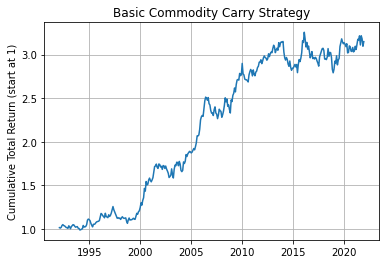

In [2165]:
fig, ax = plt.subplots()
ax.plot(combined_carry_test["x"], combined_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry Strategy')

ax.grid()

fig.savefig("basic_carry_cum_return.png")
plt.show()

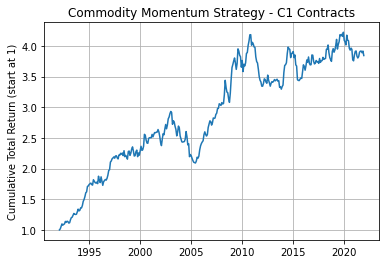

In [2166]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_test["x"], combined_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum Strategy - C1 Contracts')

ax.grid()

fig.savefig("momentum_c1_cum_return.png")
plt.show()

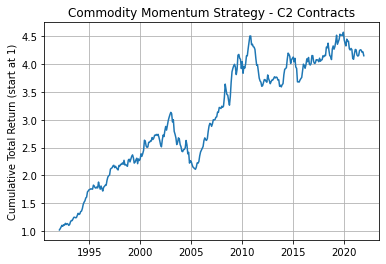

In [2167]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_c2_test["x"], combined_momentum_c2_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum Strategy - C2 Contracts')

ax.grid()

fig.savefig("momentum_c2_cum_return.png")
plt.show()

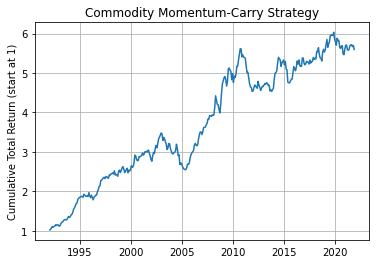

In [2168]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_carry_test["x"], combined_momentum_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum-Carry Strategy')

ax.grid()

fig.savefig("momentum_carry_cum_return.png")
plt.show()

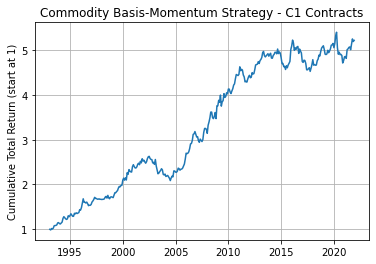

In [2169]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_test["x"], combined_basis_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum Strategy - C1 Contracts')

ax.grid()

fig.savefig("basis_momentum_c1_cum_return.png")
plt.show()

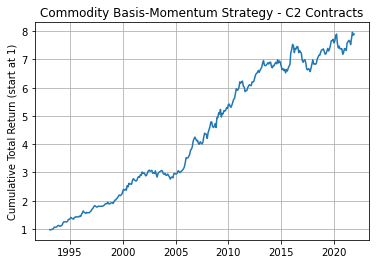

In [2170]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_c2_test["x"], combined_basis_momentum_c2_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum Strategy - C2 Contracts')

ax.grid()

fig.savefig("basis_momentum_c2_cum_return.png")
plt.show()

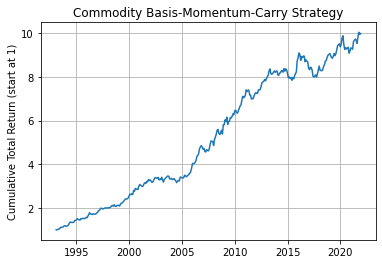

In [2171]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_carry_test["x"], combined_basis_momentum_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum-Carry Strategy')

ax.grid()

fig.savefig("basis_momentum_carry_cum_return.png")
plt.show()

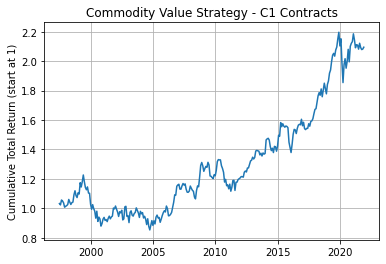

In [2172]:
fig, ax = plt.subplots()
ax.plot(combined_value_test["x"], combined_value_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value Strategy - C1 Contracts')

ax.grid()

fig.savefig("value_c1_cum_return.png")
plt.show()

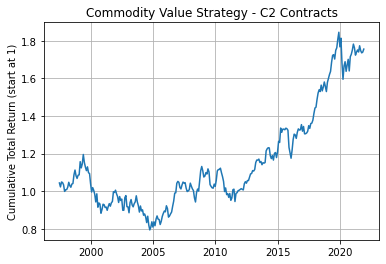

In [2173]:
fig, ax = plt.subplots()
ax.plot(combined_value_c2_test["x"], combined_value_c2_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value Strategy - C2 Contracts')

ax.grid()

fig.savefig("value_c2_cum_return.png")
plt.show()

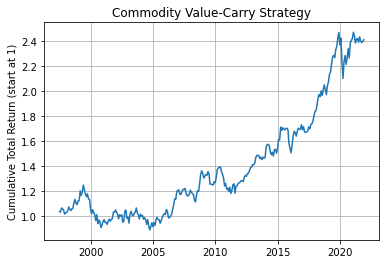

In [2174]:
fig, ax = plt.subplots()
ax.plot(combined_value_carry_test["x"], combined_value_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value-Carry Strategy')

ax.grid()

fig.savefig("value_carry_cum_return.png")
plt.show()

# Output Tables

First we calculate excess returns & drawdowns for every strategy

In [2175]:
# Calculate maximum drawdown
ew_commodity_test["y_cum_max"] = ew_commodity_test.y_cum.cummax()
ew_commodity_test["drawdown"] = ew_commodity_test["y_cum"] / ew_commodity_test["y_cum_max"] - 1

In [2176]:
# Calculate excess returns
ew_commodity_test["excess_ret"] = ew_commodity_test["y"] - ew_commodity_test["rf"]

In [2177]:
# Calculate maximum drawdown
combined_carry_test["y_cum_max"] = combined_carry_test.y_cum.cummax()
combined_carry_test["drawdown"] = combined_carry_test["y_cum"] / combined_carry_test["y_cum_max"] - 1

In [2178]:
# Calculate excess returns
combined_carry_test["excess_ret"] = combined_carry_test["y"] - combined_carry_test["rf"]

In [2179]:
# Calculate maximum drawdown
combined_momentum_test["y_cum_max"] = combined_momentum_test.y_cum.cummax()
combined_momentum_test["drawdown"] = combined_momentum_test["y_cum"] / combined_momentum_test["y_cum_max"] - 1

In [2180]:
# Calculate excess returns
combined_momentum_test["excess_ret"] = combined_momentum_test["y"] - combined_momentum_test["rf"]

In [2181]:
# Calculate maximum drawdown
combined_momentum_c2_test["y_cum_max"] = combined_momentum_c2_test.y_cum.cummax()
combined_momentum_c2_test["drawdown"] = combined_momentum_c2_test["y_cum"] / combined_momentum_c2_test["y_cum_max"] - 1

In [2182]:
# Calculate excess returns
combined_momentum_c2_test["excess_ret"] = combined_momentum_c2_test["y"] - combined_momentum_c2_test["rf"]

In [2183]:
# Calculate maximum drawdown
combined_basis_momentum_test["y_cum_max"] = combined_basis_momentum_test.y_cum.cummax()
combined_basis_momentum_test["drawdown"] = combined_basis_momentum_test["y_cum"] / combined_basis_momentum_test["y_cum_max"] - 1

In [2184]:
# Calculate excess returns
combined_basis_momentum_test["excess_ret"] = combined_basis_momentum_test["y"] - combined_basis_momentum_test["rf"]

In [2185]:
# Calculate maximum drawdown
combined_basis_momentum_c2_test["y_cum_max"] = combined_basis_momentum_c2_test.y_cum.cummax()
combined_basis_momentum_c2_test["drawdown"] = combined_basis_momentum_c2_test["y_cum"] / combined_basis_momentum_c2_test["y_cum_max"] - 1

In [2186]:
# Calculate excess returns
combined_basis_momentum_c2_test["excess_ret"] = combined_basis_momentum_c2_test["y"] - combined_basis_momentum_c2_test["rf"]

In [2187]:
# Calculate maximum drawdown
combined_value_test["y_cum_max"] = combined_value_test.y_cum.cummax()
combined_value_test["drawdown"] = combined_value_test["y_cum"] / combined_value_test["y_cum_max"] - 1

In [2188]:
# Calculate excess returns
combined_value_test["excess_ret"] = combined_value_test["y"] - combined_value_test["rf"]

In [2189]:
# Calculate maximum drawdown
combined_value_c2_test["y_cum_max"] = combined_value_c2_test.y_cum.cummax()
combined_value_c2_test["drawdown"] = combined_value_c2_test["y_cum"] / combined_value_c2_test["y_cum_max"] - 1

In [2190]:
# Calculate excess returns
combined_value_c2_test["excess_ret"] = combined_value_c2_test["y"] - combined_value_c2_test["rf"]

In [2191]:
# Calculate maximum drawdown
combined_momentum_carry_test["y_cum_max"] = combined_momentum_carry_test.y_cum.cummax()
combined_momentum_carry_test["drawdown"] = combined_momentum_carry_test["y_cum"] / combined_momentum_carry_test["y_cum_max"] - 1

In [2192]:
# Calculate excess returns
combined_momentum_carry_test["excess_ret"] = combined_momentum_carry_test["y"] - combined_momentum_carry_test["rf"]

In [2193]:
# Calculate maximum drawdown
combined_basis_momentum_carry_test["y_cum_max"] = combined_basis_momentum_carry_test.y_cum.cummax()
combined_basis_momentum_carry_test["drawdown"] = combined_basis_momentum_carry_test["y_cum"] / combined_basis_momentum_carry_test["y_cum_max"] - 1

In [2194]:
# Calculate excess returns
combined_basis_momentum_carry_test["excess_ret"] = combined_basis_momentum_carry_test["y"] - combined_basis_momentum_carry_test["rf"]

In [2195]:
# Calculate maximum drawdown
combined_value_carry_test["y_cum_max"] = combined_value_carry_test.y_cum.cummax()
combined_value_carry_test["drawdown"] = combined_value_carry_test["y_cum"] / combined_value_carry_test["y_cum_max"] - 1

In [2196]:
# Calculate excess returns
combined_value_carry_test["excess_ret"] = combined_value_carry_test["y"] - combined_value_carry_test["rf"]

In [2197]:
from scipy.stats import gmean

## Momentum Table

In [2198]:
# First we properly merge the tables together
ew_commodity_test["Strategy"] = "Equal Weighted Commodity"
combined_carry_test["Strategy"] = "Carry"
combined_momentum_test["Strategy"] = "Momentum - C1"
combined_momentum_c2_test["Strategy"] = "Momentum - C2"
combined_momentum_carry_test["Strategy"] = "Momentum-Carry"

table_1 = pd.concat([
    ew_commodity_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_momentum_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_momentum_c2_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_momentum_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]]
])

table_1 = table_1.merge(combined_momentum_carry_test[["x"]], how="right")

In [2199]:
# Then we aggregate them
table_1.groupby(
    "Strategy"
).agg(
    mean_monthly_return = ("y", lambda x: np.mean(x) - 1),
    mean_geo_monthly_return = ("y", lambda x: gmean(x) - 1),
    monthly_volatility = ("y", np.std),
    monthly_sharpe_ratio = (
        "excess_ret", lambda x: (np.mean(x) - 1) / np.std(x)
    ),
    yearly_sharpe_ratio = (
        "excess_ret", lambda x: np.sqrt(12) * (np.mean(x) - 1) / np.std(x)
    ),
    maximum_drawdown = ("drawdown", np.min)
).transpose()

Strategy,Carry,Equal Weighted Commodity,Momentum - C1,Momentum - C2,Momentum-Carry
mean_monthly_return,0.003414,0.004114,0.004061,0.004253,0.005090
mean_geo_monthly_return,0.003200,0.003615,0.003757,0.003971,0.004809
monthly_volatility,0.020817,0.031427,0.024765,0.023807,0.023815
monthly_sharpe_ratio,0.062540,0.063680,0.079286,0.090764,0.126297
yearly_sharpe_ratio,0.216645,0.220595,0.274653,0.314416,0.437506
maximum_drawdown,-0.152728,-0.429006,-0.286798,-0.326380,-0.266327


## Basis-Momentum Table

In [2200]:
# First we properly merge the tables together
ew_commodity_test["Strategy"] = "Equal Weighted Commodity"
combined_carry_test["Strategy"] = "Carry"
combined_basis_momentum_test["Strategy"] = "Basis-Momentum - C1"
combined_basis_momentum_c2_test["Strategy"] = "Basis-Momentum - C2"
combined_basis_momentum_carry_test["Strategy"] = "Basis-Momentum-Carry"

table_2 = pd.concat([
    ew_commodity_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_basis_momentum_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_basis_momentum_c2_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_basis_momentum_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]]
])

table_2 = table_2.merge(combined_basis_momentum_carry_test[["x"]], how="right")

In [2201]:
# Then we aggregate them
table_2.groupby(
    "Strategy"
).agg(
    mean_monthly_return = ("y", lambda x: np.mean(x) - 1),
    mean_geo_monthly_return = ("y", lambda x: gmean(x) - 1),
    monthly_volatility = ("y", np.std),
    monthly_sharpe_ratio = (
        "excess_ret", lambda x: (np.mean(x) - 1) / np.std(x)
    ),
    yearly_sharpe_ratio = (
        "excess_ret", lambda x: np.sqrt(12) * (np.mean(x) - 1) / np.std(x)
    ),
    maximum_drawdown = ("drawdown", np.min)
).transpose()

Strategy,Basis-Momentum - C1,Basis-Momentum - C2,Basis-Momentum-Carry,Carry,Equal Weighted Commodity
mean_monthly_return,0.005020,0.006170,0.006864,0.003421,0.004181
mean_geo_monthly_return,0.004775,0.005971,0.006657,0.003202,0.003667
monthly_volatility,0.022245,0.020063,0.020490,0.021038,0.031882
monthly_sharpe_ratio,0.133423,0.206449,0.236386,0.063907,0.065988
yearly_sharpe_ratio,0.462192,0.715161,0.818864,0.221380,0.228590
maximum_drawdown,-0.206133,-0.127889,-0.122433,-0.152728,-0.429006


## Value Table

In [2202]:
# First we properly merge the tables together
ew_commodity_test["Strategy"] = "Equal Weighted Commodity"
combined_carry_test["Strategy"] = "Carry"
combined_value_test["Strategy"] = "Value - C1"
combined_value_c2_test["Strategy"] = "Value - C2"
combined_value_carry_test["Strategy"] = "Value-Carry"

table_3 = pd.concat([
    ew_commodity_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_value_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_value_c2_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_value_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]]
])

table_3 = table_3.merge(combined_value_carry_test[["x"]], how="right")

In [2203]:
# Then we aggregate them
table_3.groupby(
    "Strategy"
).agg(
    mean_monthly_return = ("y", lambda x: np.mean(x) - 1),
    mean_geo_monthly_return = ("y", lambda x: gmean(x) - 1),
    monthly_volatility = ("y", np.std),
    monthly_sharpe_ratio = (
        "excess_ret", lambda x: (np.mean(x) - 1) / np.std(x)
    ),
    yearly_sharpe_ratio = (
        "excess_ret", lambda x: np.sqrt(12) * (np.mean(x) - 1) / np.std(x)
    ),
    maximum_drawdown = ("drawdown", np.min)
).transpose()

Strategy,Carry,Equal Weighted Commodity,Value - C1,Value - C2,Value-Carry
mean_monthly_return,0.003448,0.003283,0.002920,0.002268,0.003383
mean_geo_monthly_return,0.003225,0.002707,0.002519,0.001917,0.003001
monthly_volatility,0.021285,0.033741,0.028365,0.026483,0.027699
monthly_sharpe_ratio,0.082563,0.046929,0.042934,0.021369,0.060674
yearly_sharpe_ratio,0.286006,0.162565,0.148727,0.074026,0.210183
maximum_drawdown,-0.152728,-0.429006,-0.304367,-0.335730,-0.288776


## All Single-Factor Table

In [2204]:
# First we properly merge the tables together
ew_commodity_test["Strategy"] = "Equal Weighted Commodity"
combined_carry_test["Strategy"] = "Carry"
combined_momentum_test["Strategy"] = "Momentum - C1"
combined_momentum_c2_test["Strategy"] = "Momentum - C2"
combined_basis_momentum_test["Strategy"] = "Basis-Momentum - C1"
combined_basis_momentum_c2_test["Strategy"] = "Basis-Momentum - C2"
combined_value_test["Strategy"] = "Value - C1"
combined_value_c2_test["Strategy"] = "Value - C2"
combined_momentum_carry_test["Strategy"] = "Momentum-Carry"
combined_basis_momentum_carry_test["Strategy"] = "Basis-Momentum-Carry"
combined_value_carry_test["Strategy"] = "Value-Carry"

table_4 = pd.concat([
    ew_commodity_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_momentum_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_momentum_c2_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_basis_momentum_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_basis_momentum_c2_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_value_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_value_c2_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_momentum_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_basis_momentum_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]],
    combined_value_carry_test[["x", "Strategy", "y", "drawdown", "excess_ret"]]
])

table_4 = table_4.merge(combined_value_carry_test[["x"]], how="right")

In [2205]:
# Then we aggregate them
table_4.groupby(
    "Strategy"
).agg(
    mean_monthly_return = ("y", lambda x: np.mean(x) - 1),
    mean_geo_monthly_return = ("y", lambda x: gmean(x) - 1),
    monthly_volatility = ("y", np.std),
    monthly_sharpe_ratio = (
        "excess_ret", lambda x: (np.mean(x) - 1) / np.std(x)
    ),
    yearly_sharpe_ratio = (
        "excess_ret", lambda x: np.sqrt(12) * (np.mean(x) - 1) / np.std(x)
    ),
    maximum_drawdown = ("drawdown", np.min)
).transpose()

Strategy,Basis-Momentum - C1,Basis-Momentum - C2,Basis-Momentum-Carry,Carry,Equal Weighted Commodity,Momentum - C1,Momentum - C2,Momentum-Carry,Value - C1,Value - C2,Value-Carry
mean_monthly_return,0.004074,0.005216,0.005737,0.003448,0.003283,0.002214,0.002471,0.003221,0.002920,0.002268,0.003383
mean_geo_monthly_return,0.003850,0.005027,0.005544,0.003225,0.002707,0.001914,0.002188,0.002942,0.002519,0.001917,0.003001
monthly_volatility,0.021288,0.019557,0.019743,0.021285,0.033741,0.024526,0.023842,0.023674,0.028365,0.026483,0.027699
monthly_sharpe_ratio,0.112539,0.181695,0.206581,0.082563,0.046929,0.021029,0.032553,0.064670,0.042934,0.021369,0.060674
yearly_sharpe_ratio,0.389847,0.629410,0.715619,0.286006,0.162565,0.072846,0.112768,0.224023,0.148727,0.074026,0.210183
maximum_drawdown,-0.206133,-0.127889,-0.122433,-0.152728,-0.429006,-0.286798,-0.326380,-0.266327,-0.304367,-0.335730,-0.288776


# Regressions

## Regression Data Construction

In [2206]:
# Add risk free rate to all strategy returns
rf_test = combined_value_carry_test.copy()
rf_test["y"] = rf_test["rf"] + 1
rf_test["Strategy"] = "Risk_Free"

regression_table = table_4.copy()

regression_table = pd.concat([
    regression_table,
    rf_test[["x", "Strategy", "y"]]
])

regression_table = regression_table.merge(combined_value_carry_test[["x"]], how="right")

In [2207]:
# Get all time series data to run regressions on
regression_table = regression_table.pivot(index="x", columns="Strategy", values="y")
regression_table = regression_table.reset_index()
regression_table.columns.name = None

In [2208]:
regression_table.rename(columns={
    "Equal Weighted Commodity": "Equal_Weighted_Commodity",
    "Basis-Momentum - C1": "Basis_Momentum_C1",
    "Basis-Momentum - C2": "Basis_Momentum_C2",
    "Basis-Momentum-Carry": "Basis_Momentum_Carry",
    "Momentum-Carry": "Momentum_Carry",
    "Value-Carry": "Value_Carry",
    "Momentum - C1": "Momentum_C1",
    "Momentum - C2" : "Momentum_C2",
    "Value - C1": "Value_C1",
    "Value - C2": "Value_C2"
}, inplace=True)

In [2209]:
# We regress on returns, now all returns are presented as 1 + r as that made the other calculations easier
regression_table = regression_table - 1
# We also regress against excess market returns, not raw market returns
for c in regression_table.columns:
    if c != "Risk_Free":
        regression_table[c] = regression_table[c] - regression_table["Risk_Free"]

## Momentum Regression

In [2210]:
import pandas as pd
import statsmodels.formula.api as smf

model_1 = smf.ols('Momentum_Carry ~ Equal_Weighted_Commodity + Carry + Momentum_C1 + Basis_Momentum_C1 + Value_C1', data = regression_table).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:         Momentum_Carry   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2134.
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          3.43e-225
Time:                        14:54:56   Log-Likelihood:                 1220.4
No. Observations:                 294   AIC:                            -2429.
Df Residuals:                     288   BIC:                            -2407.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## Basis-Momentum Regression

In [2211]:
import pandas as pd
import statsmodels.formula.api as smf

model_2 = smf.ols('Basis_Momentum_Carry ~ Equal_Weighted_Commodity + Carry + Momentum_C1 + Basis_Momentum_C1 + Value_C1', data = regression_table).fit()

print(model_2.summary())

                             OLS Regression Results                             
Dep. Variable:     Basis_Momentum_Carry   R-squared:                       0.903
Model:                              OLS   Adj. R-squared:                  0.902
Method:                   Least Squares   F-statistic:                     539.0
Date:                  Tue, 05 Jul 2022   Prob (F-statistic):          7.18e-144
Time:                          14:54:56   Log-Likelihood:                 1083.5
No. Observations:                   294   AIC:                            -2155.
Df Residuals:                       288   BIC:                            -2133.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inte

## Value Regression

In [2212]:
import pandas as pd
import statsmodels.formula.api as smf

model_3 = smf.ols('Value_Carry ~ Equal_Weighted_Commodity + Carry + Momentum_C1 + Basis_Momentum_C1 + Value_C1', data = regression_table).fit()

print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:            Value_Carry   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4515.
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          3.57e-271
Time:                        14:54:56   Log-Likelihood:                 1279.9
No. Observations:                 294   AIC:                            -2548.
Df Residuals:                     288   BIC:                            -2526.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## All models

In [2213]:
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

stargazer = Stargazer([model_1, model_2, model_3])

HTML(stargazer.render_html())

# Exploratory Analysis

In [2214]:
negative_momentum_carry_v3_pick_share.pick_share.mean()

0.6896361144272

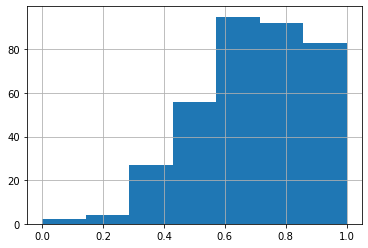

In [2215]:
negative_momentum_carry_v3_pick_share.pick_share.hist(bins=7)

In [2216]:
positive_momentum_carry_v3_pick_share.pick_share.mean()

0.401524295883628

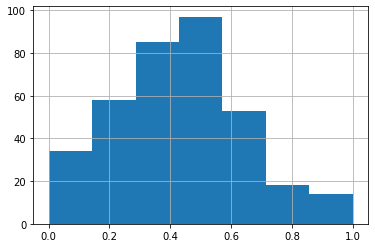

In [2217]:
positive_momentum_carry_v3_pick_share.pick_share.hist(bins=7)

In [2218]:
negative_basis_momentum_carry_pick_share.pick_share.mean()

0.7970872787155213

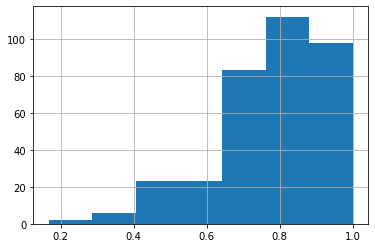

In [2219]:
negative_basis_momentum_carry_pick_share.pick_share.hist(bins=7)

In [2220]:
positive_basis_momentum_carry_pick_share.pick_share.mean()

0.5528887059146417

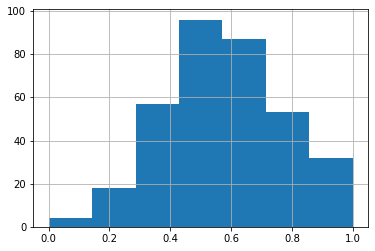

In [2221]:
positive_basis_momentum_carry_pick_share.pick_share.hist(bins=7)

In [2222]:
negative_value_carry_pick_share.pick_share.mean()

0.5536740092862541

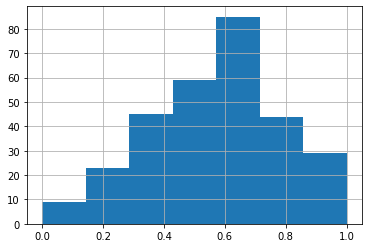

In [2223]:
negative_value_carry_pick_share.pick_share.hist(bins=7)

In [2224]:
positive_value_carry_pick_share.pick_share.mean()

0.22817595292085108

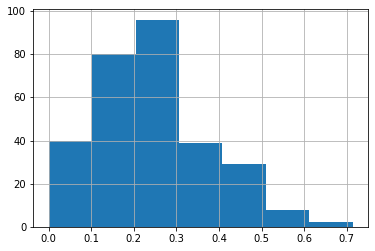

In [2225]:
positive_value_carry_pick_share.pick_share.hist(bins=7)